In [1]:
from datetime import date
from glob import glob
import os, sys
from os import makedirs
from os.path import join, dirname
from tqdm import tqdm

import pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
# import statsmodels.stats.multitest

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib import patches, lines

from scipy import optimize, stats

from nilearn import plotting, masking, image
from nilearn.input_data import NiftiLabelsMasker

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, auc
from sklearn.preprocessing import StandardScaler

import pingouin as pg

import random
# from random import random as rand

# import pingouin as pg

/home/sungbeenpark/anaconda3/envs/GL/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
%matplotlib inline

In [3]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [4]:
dir_root = join('/mnt/ext4/GL/fmri_data')
dir_stat = join(dir_root,'stats/AM/GLM.reward_per_trial/4s_shifted')
dir_mask = join(dir_root,'masks')

dir_cache = '/home/sungbeenpark/trash/nilearn_cache'

---

In [5]:
p_thresh = 5.e-5
# p_thresh = 5.e-2
z_thresh = stats.norm.isf(0.5*p_thresh)
print(z_thresh)

4.0556269811224


In [6]:
fname = join(dir_stat,'3dttest++.reward.main.n24.nii')
img = image.load_img(fname)
img_stat = image.threshold_img(
    img.slicer[:,:,:,0,1],
    threshold=z_thresh,
    cluster_threshold=450,
    two_sided=False
)

/home/sungbeenpark/anaconda3/envs/GL/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


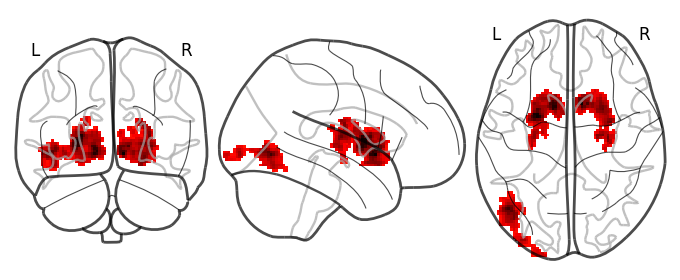

In [7]:
plotting.plot_glass_brain(img_stat)

---

## fig 2-a.

In [8]:
p_thresh = 5.e-3
# p_thresh = 5.e-2
z_thresh = stats.norm.isf(0.5*p_thresh)
print(z_thresh)

2.8070337683438042


/home/sungbeenpark/anaconda3/envs/GL/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



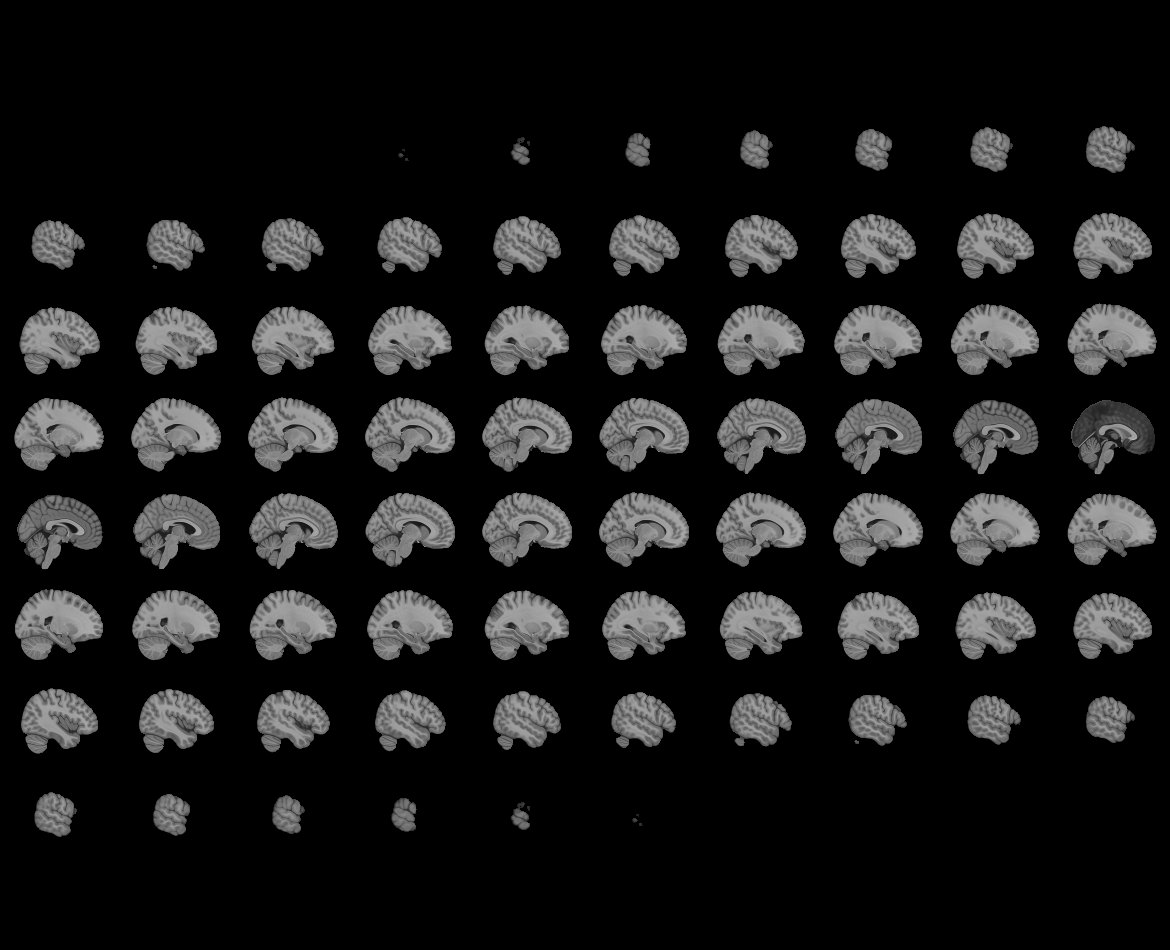
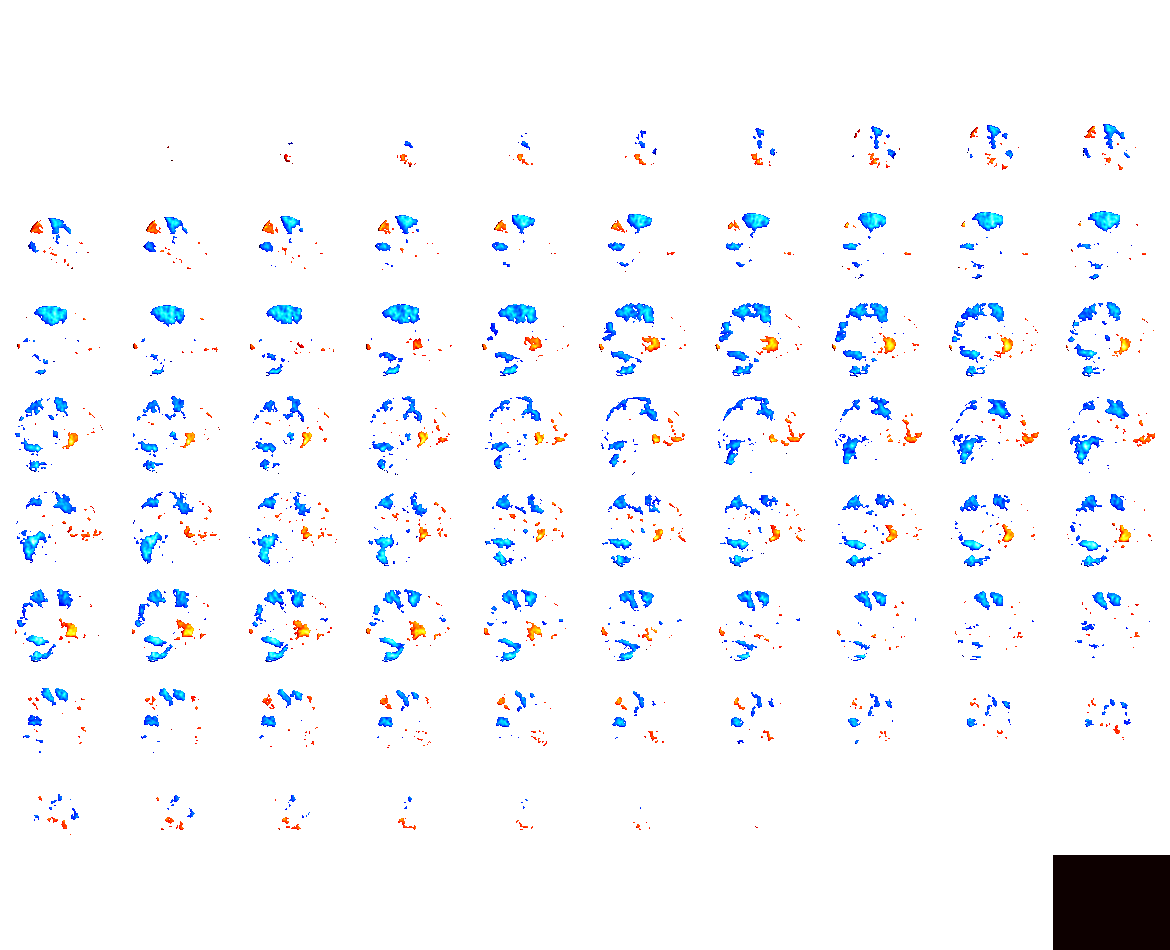

In [9]:
fname = join(dir_stat,'3dttest++.paired.reward.on-off.n24.nii')
img = image.load_img(fname)
plotting.view_img(
    img.slicer[:,:,:,0,3],
    threshold=z_thresh,
#     vmax=6.8
)

/home/sungbeenpark/anaconda3/envs/GL/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



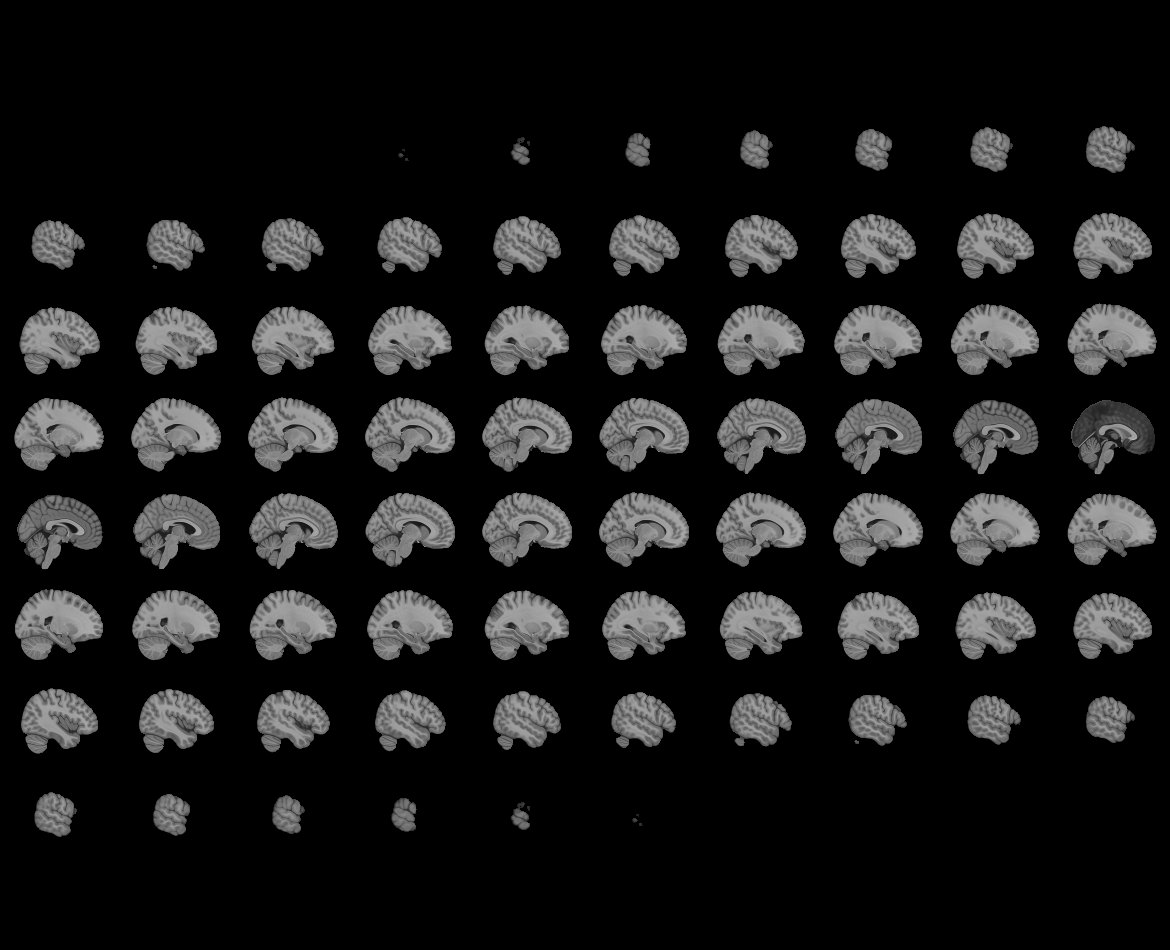
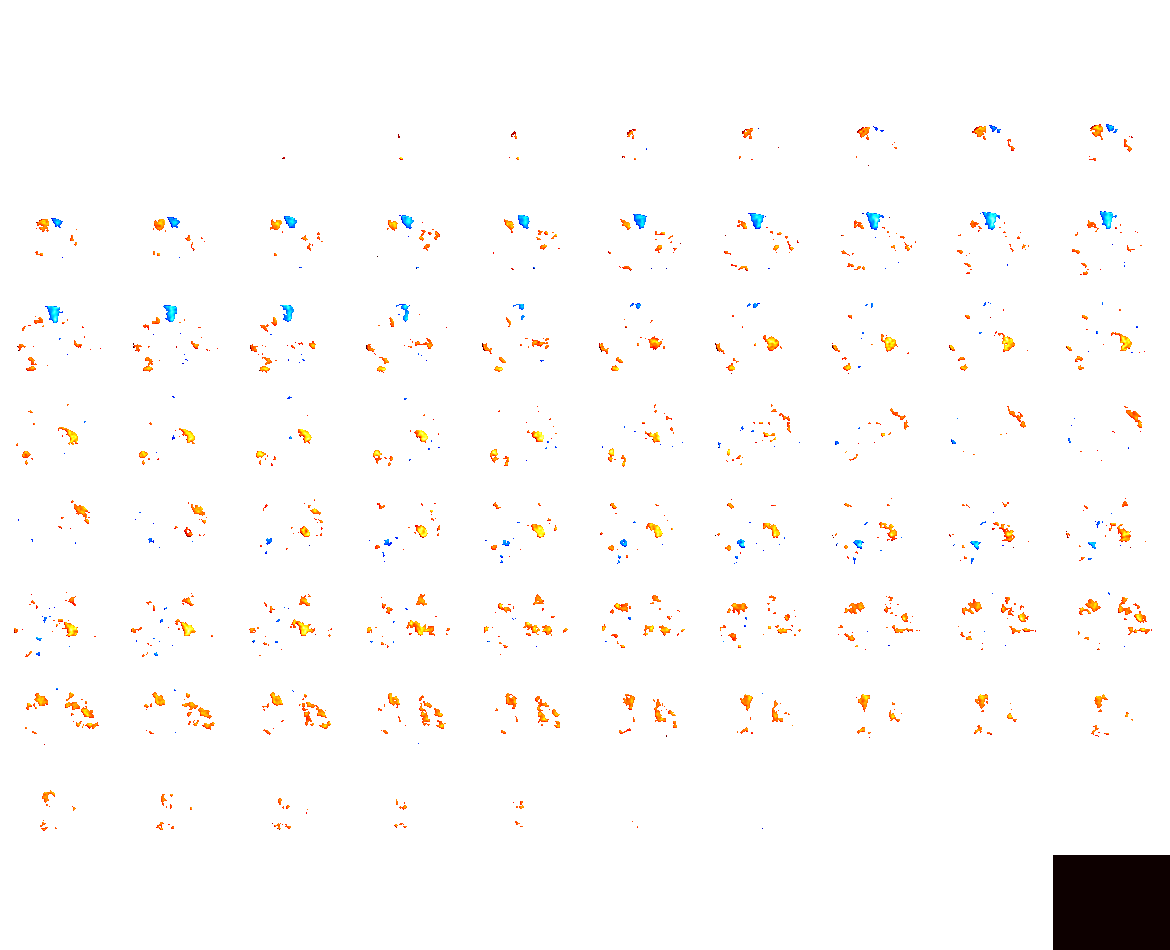

In [10]:
fname = join(dir_stat,'3dttest++.paired.reward.on-off.n24.nii')
img = image.load_img(fname)
plotting.view_img(
    img.slicer[:,:,:,0,5],
    threshold=z_thresh,
#     vmax=6.8
)

/home/sungbeenpark/anaconda3/envs/GL/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



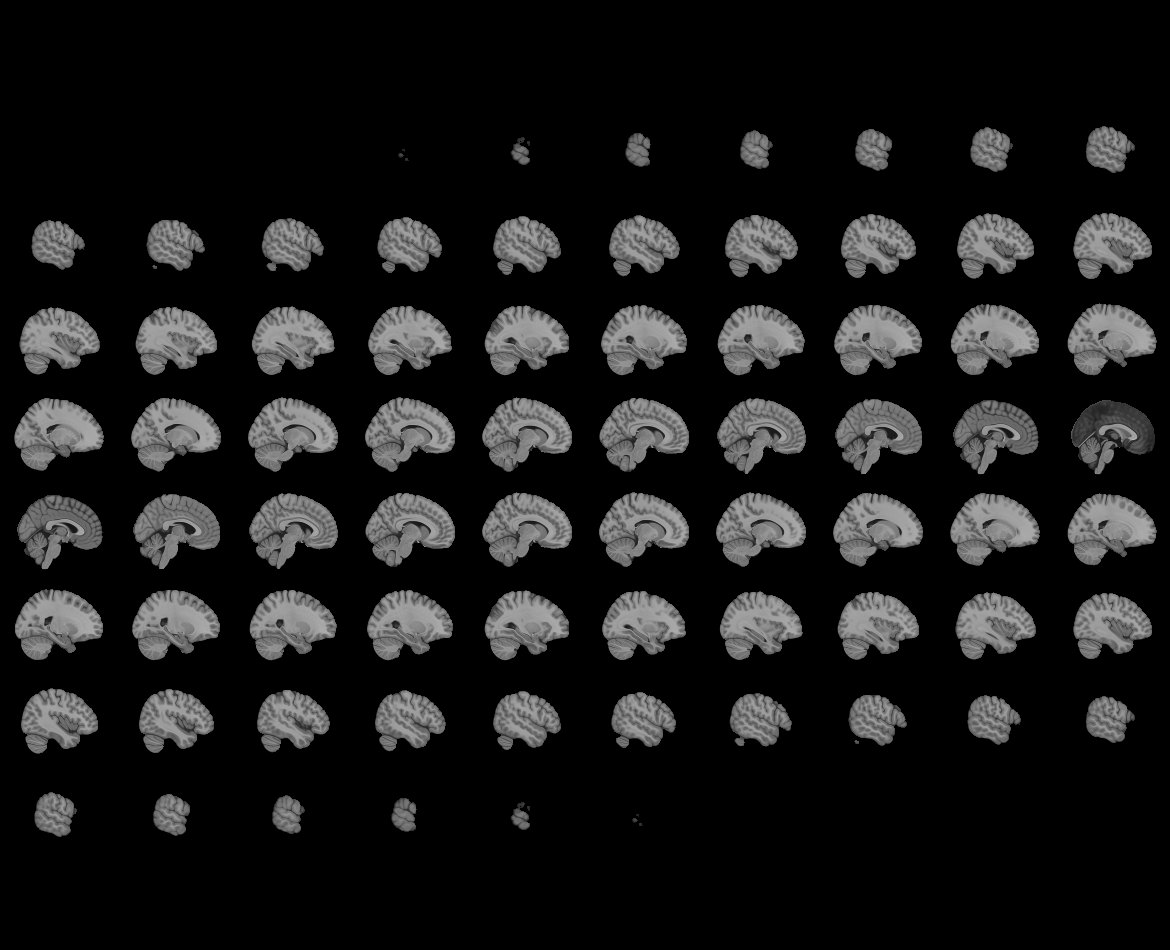
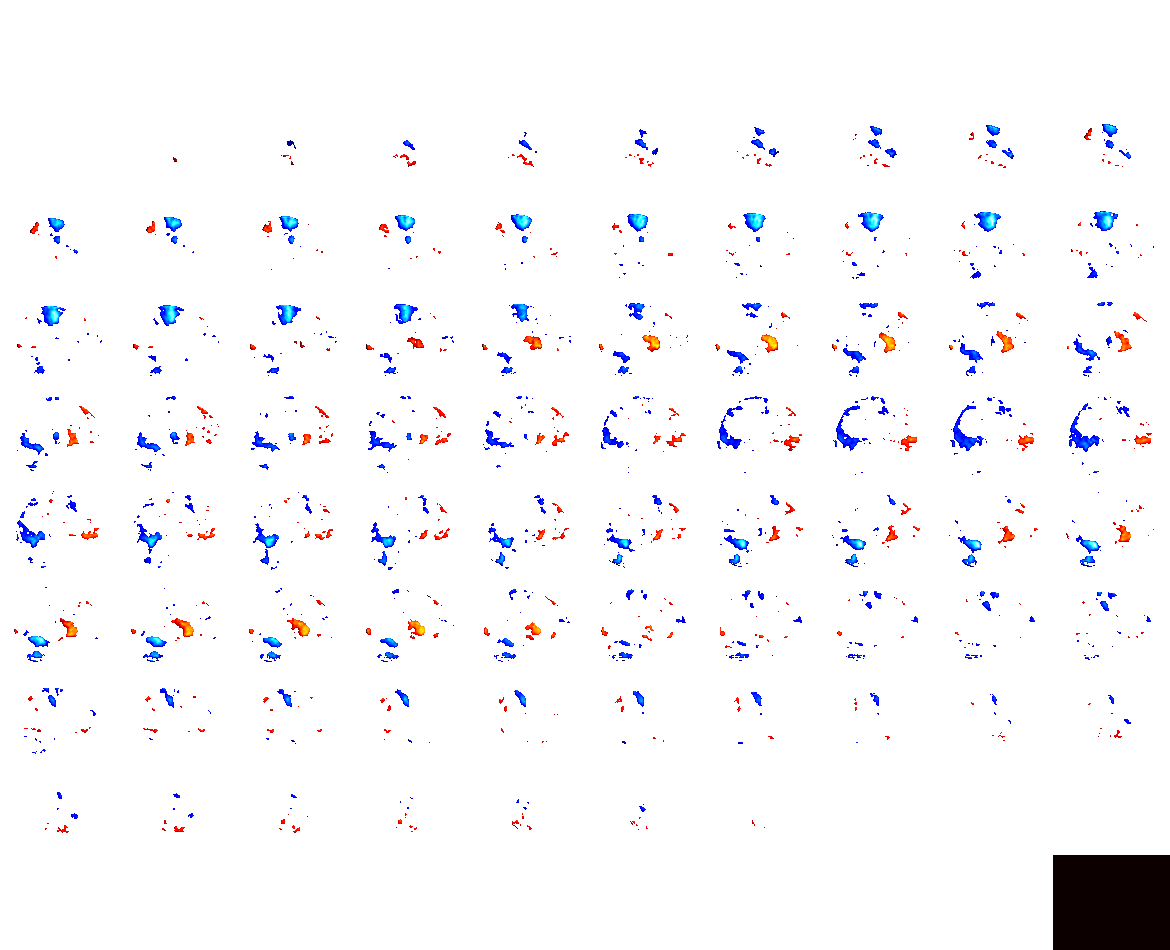

In [11]:
fname = join(dir_stat,'3dttest++.reward.test.n24.nii')
img = image.load_img(fname)
plotting.view_img(
    img.slicer[:,:,:,0,1],
    threshold=z_thresh,
#     vmax=6.8
)

In [12]:
vmax=6.8

(0.0, 1.0)

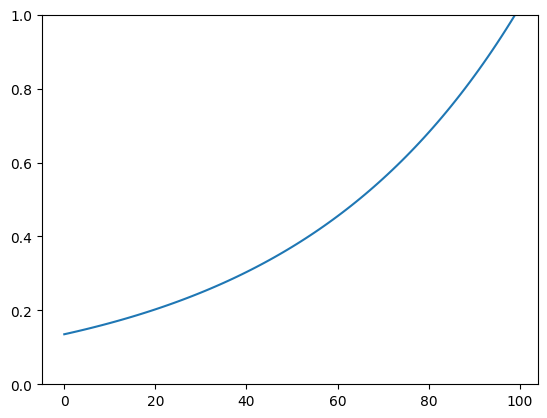

In [13]:
y = np.exp(np.linspace(-2, 0, 100))
plt.plot(y)
plt.ylim(0,1)

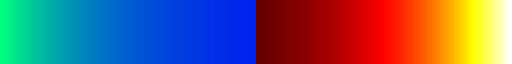

In [14]:
cmap = colors.ListedColormap(
    np.concatenate(
        [
            np.flip(cm.winter(y), axis=0)
            , cm.hot(y)
        ]
        , axis=0
    )
)
cmap

In [15]:
list_cond = ['On', 'Off', 'Test']
# list_cond = ['On', 'Off']

In [16]:
view_cut = {}
# view_cut['sagittal'] = [-55, -22, -7, -3 , 7, 22, 55]
# view_cut['axial'] = [-2, 2, 7, 10, 44, 55]
view_cut['axial'] = [-2]

/tmp/ipykernel_1290559/879842643.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


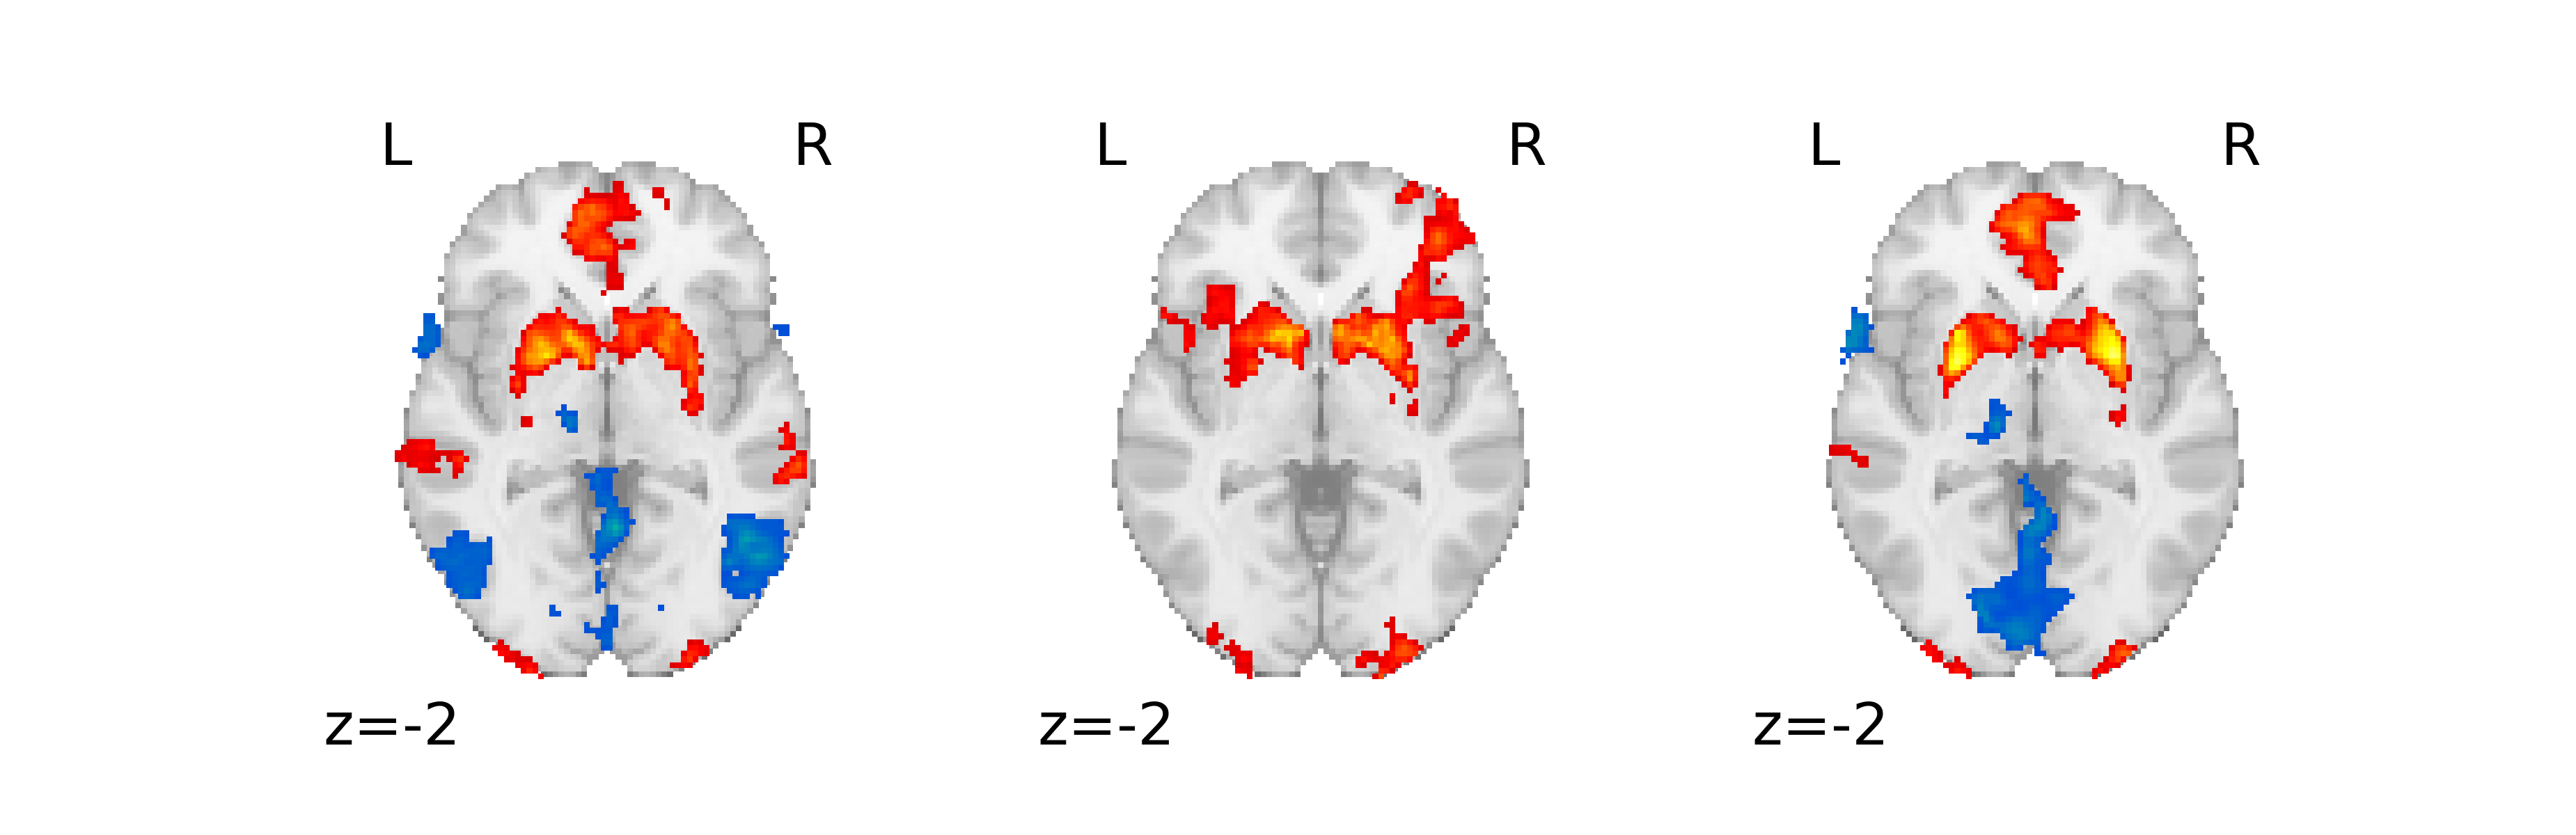

In [17]:
ncols = len(list_cond)
fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(2.5*ncols,2.5), dpi=500)

for ii, cond in enumerate(list_cond):
    if cond == 'Test':
        fname = join(dir_stat,'3dttest++.reward.test.n24.nii')
        img = image.load_img(fname)
        img = img.slicer[:,:,:,0,1]
    else:
        fname = join(dir_stat,'3dttest++.paired.reward.on-off.n24.nii')
        img = image.load_img(fname)
        if cond == 'On':
            img = img.slicer[:,:,:,0,3]
        elif cond == 'Off':
            img = img.slicer[:,:,:,0,5]
            
    for jj, (axis, coord) in enumerate(view_cut.items()):
        ax = axs[ii]
        
        img_stat = image.threshold_img(
            img,
            threshold=z_thresh,
            cluster_threshold=80,
            two_sided=True
        )
        
        g = plotting.plot_stat_map(
            img_stat
            , display_mode='x' if axis=='sagittal' else 'z'
            , cut_coords=coord
            , symmetric_cbar=False, vmax=vmax
            , cmap=cmap, colorbar=False
            , axes=ax
        )
fig.tight_layout()

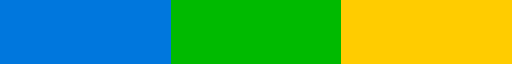

In [18]:
tmp = cm.nipy_spectral.resampled(5)
palette = tmp(np.linspace(0,1,6))[1:4]
colors.ListedColormap(palette)

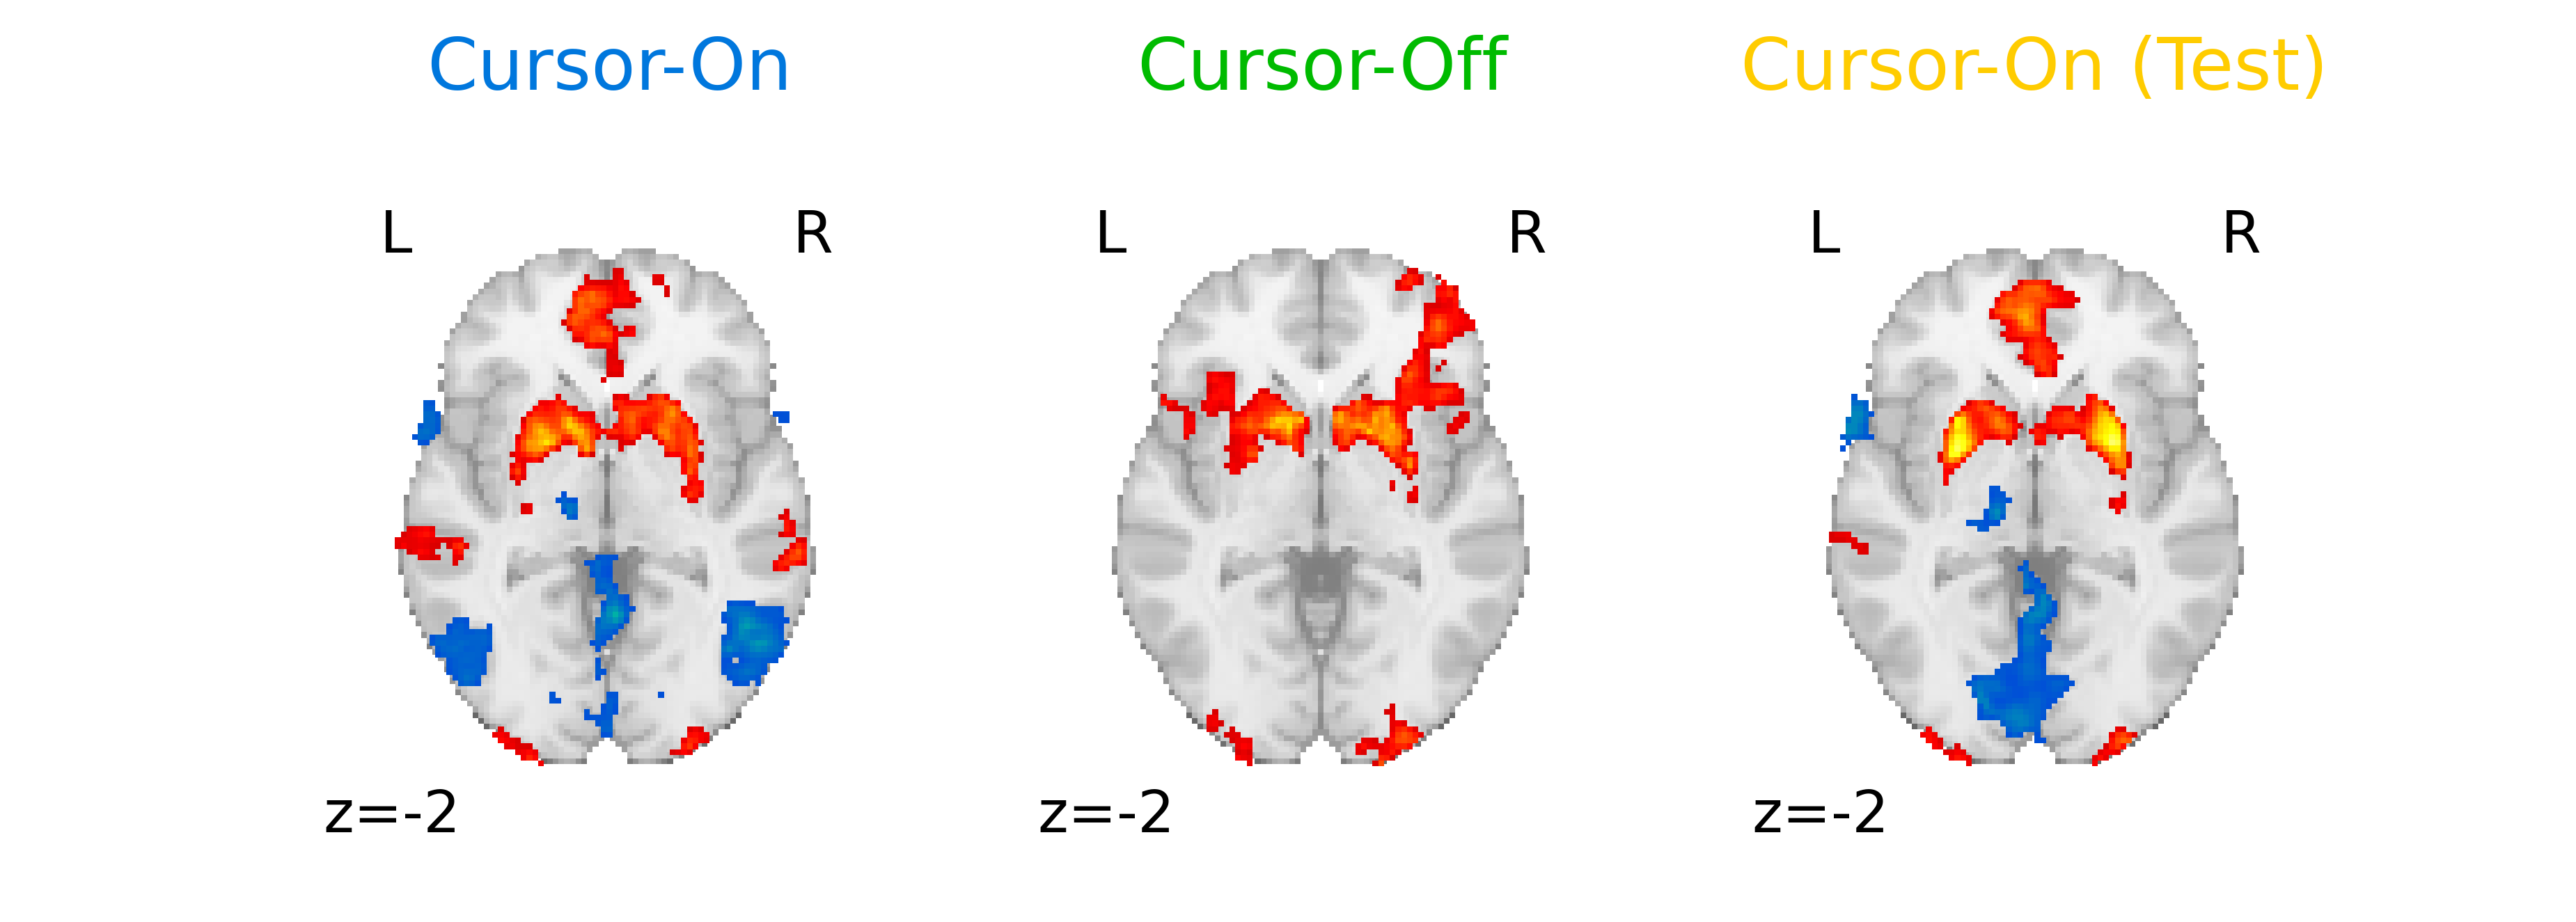

In [19]:
list_ = ['Cursor-On', 'Cursor-Off', 'Cursor-On (Test)']

## titles
for ii, cond in enumerate(list_cond):
    color = palette[ii]
    cond = list_[ii]
    x = 0.24+0.273*ii if ncols==3 else (0.3+0.425*ii if ncols==2 else 'invalid')
    fig.text(
        x,
        1.0,
        cond, size=15, rotation=0, color=color,
        ha='center', va='center',
#         bbox=dict(
#             boxstyle='round'
#             , ec=color
#             , fc=colors.to_rgb(color)/np.max(colors.to_rgb(color))
#         )
    )
    
fig

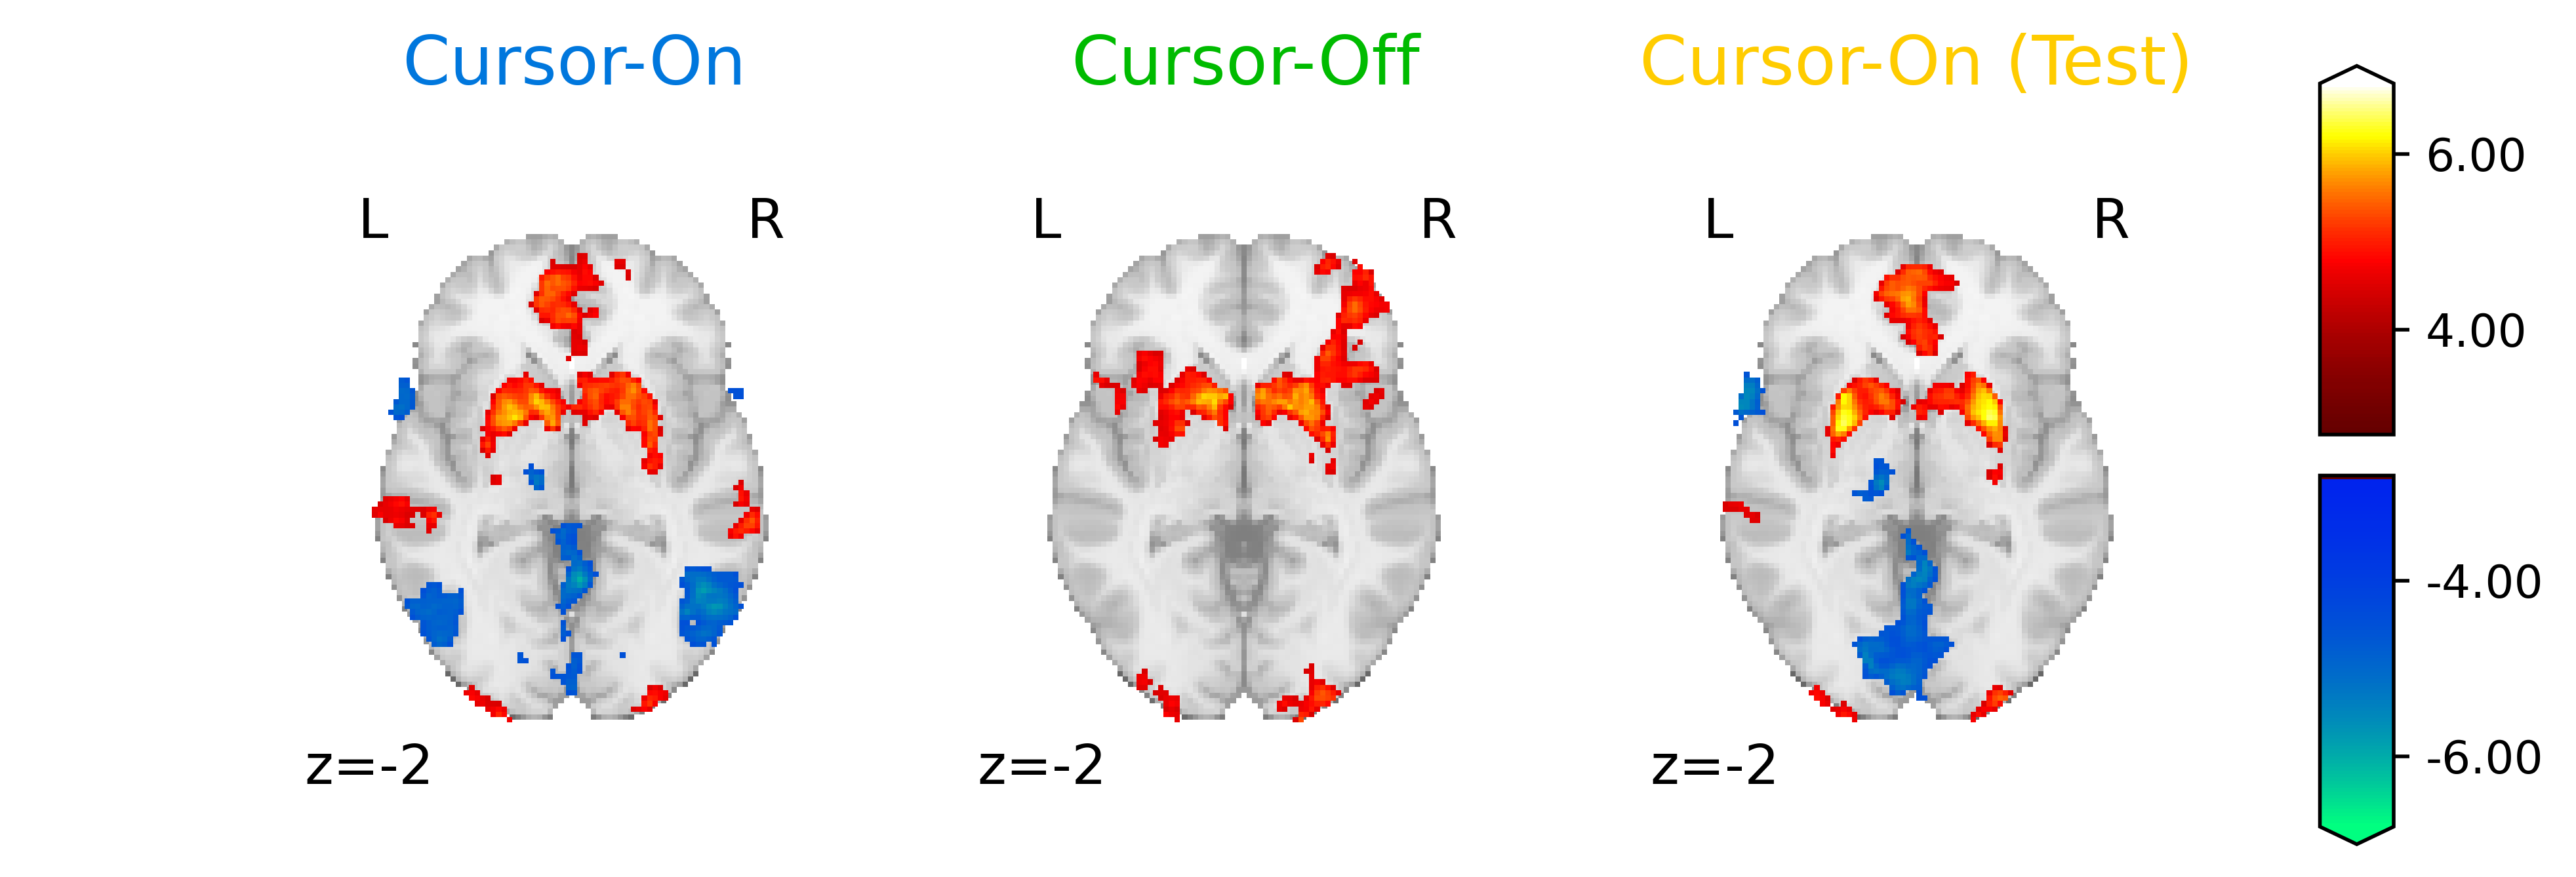

In [20]:
################
## upper cmap ##
################

### 컬러바 생성
colormapping = cm.ScalarMappable(
    norm=colors.Normalize(vmin=z_thresh, vmax=vmax),
    cmap=colors.ListedColormap(cmap(np.linspace(0.5, 1, 100)))
)
### 컬러바 삽입
cax = fig.add_axes([0.95, 0.55, .03, 0.45])
cbar = fig.colorbar(
    colormapping, extend='max'
    , orientation='vertical'
    , format='%.2f'
    , cax=cax
)

################
## lower cmap ##
################

### 컬러바 생성
colormapping = cm.ScalarMappable(
    norm=colors.Normalize(vmin=-vmax, vmax=-z_thresh),
    cmap=colors.ListedColormap(cmap(np.linspace(0, 0.5, 100)))
)
### 컬러바 삽입
cax = fig.add_axes([0.95, 0.05, .03, 0.45])
cbar = fig.colorbar(
    colormapping, extend='min'
    , orientation='vertical'
    , format='%.2f'
    , cax=cax
)

fig

In [21]:
# fig.savefig(
#     '/home/sungbeenpark/Github/labs/GL/results/fig.2-a.png'
#     , dpi=300, facecolor=[1,1,1,1]
#     , bbox_inches = "tight"
# )

---

## fig 2-b.

In [22]:
fname_roi = {}
fname_roi['full'] = join(dir_mask, 'full_mask.GL+tlrc.nii')
fname_roi['striatum'] = join(dir_mask, 'mask.striatum.nii')

/home/sungbeenpark/anaconda3/envs/GL/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



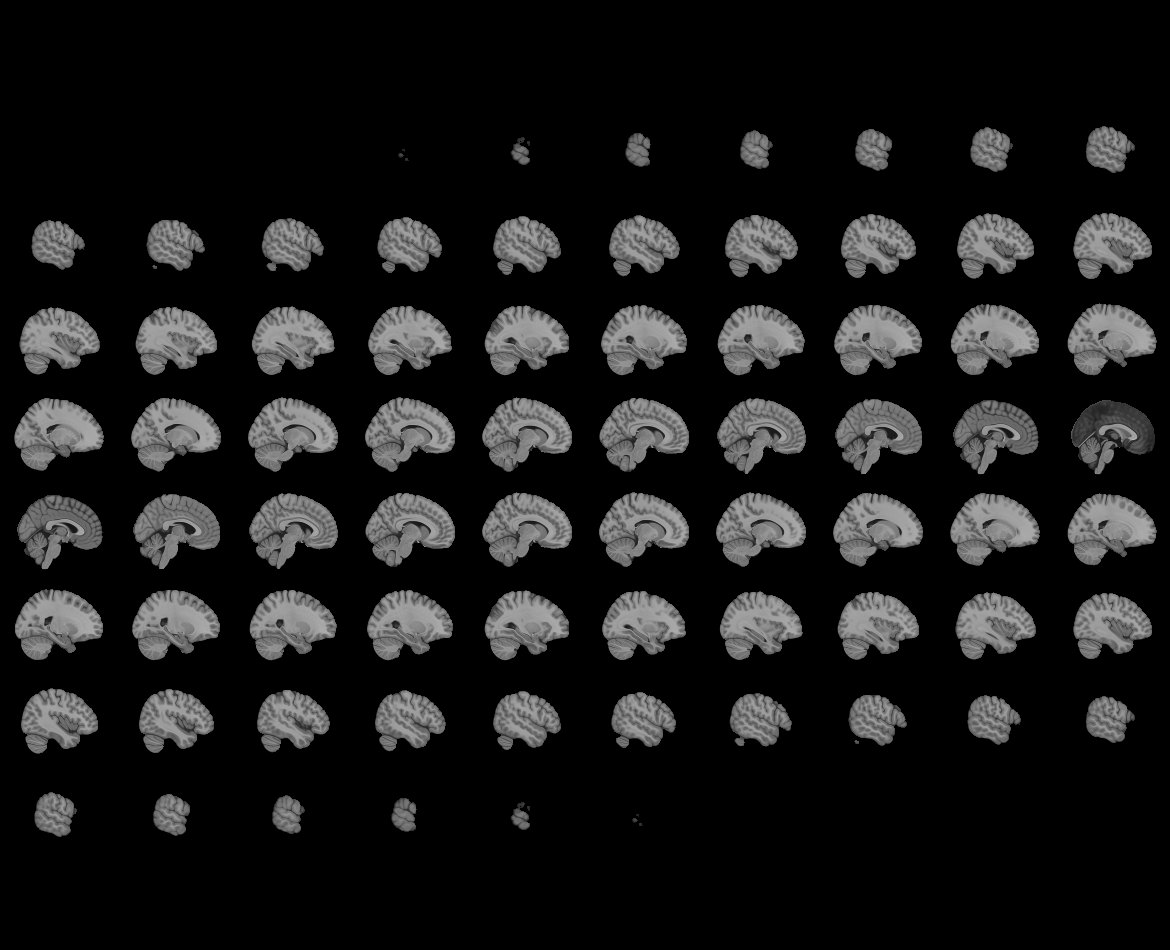
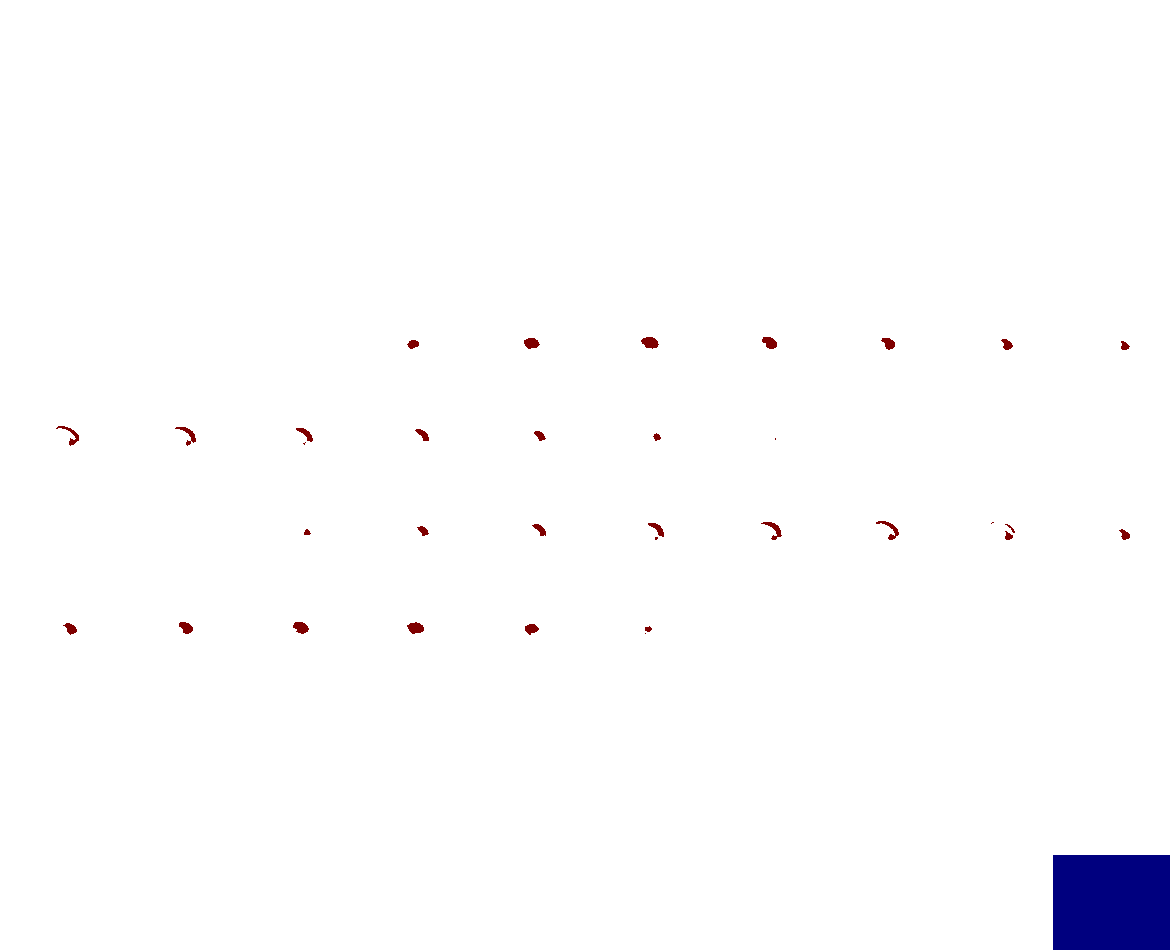

In [23]:
plotting.view_img(
    stat_map_img=fname_roi['striatum']
    , cmap=cm.jet.resampled(2)
    , symmetric_cmap=False
    , resampling_interpolation='nearest'
    , opacity=0.7
)

In [24]:
img_roi = {}
for region, fname in fname_roi.items():
    img_roi[region] = image.load_img(img=fname)

In [25]:
pval = 1.e-3
z_th = stats.norm.isf(pval*0.5)

In [26]:
img_stat = {}
for ii, cond in enumerate(['On','Off','Test']):
    if cond == 'Test':
        fname = join(dir_stat,'3dttest++.reward.test.n24.nii')
        img = image.load_img(fname)
        img = img.slicer[:,:,:,0,1]
    else:
        fname = join(dir_stat,'3dttest++.paired.reward.on-off.n24.nii')
        img = image.load_img(fname)
        if cond == 'On':
            img = img.slicer[:,:,:,0,3]
        elif cond == 'Off':
            img = img.slicer[:,:,:,0,5]

    img_stat[cond] = img

/home/sungbeenpark/anaconda3/envs/GL/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



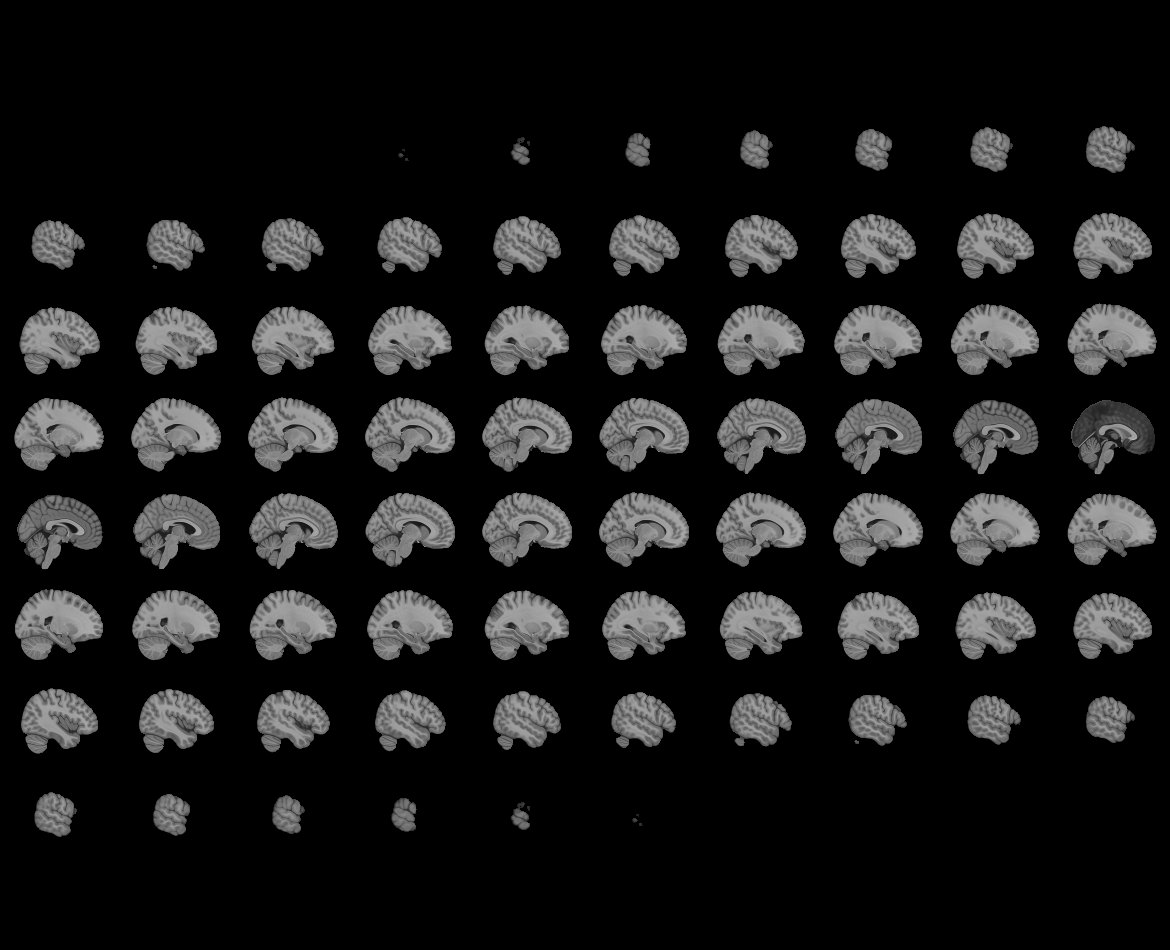
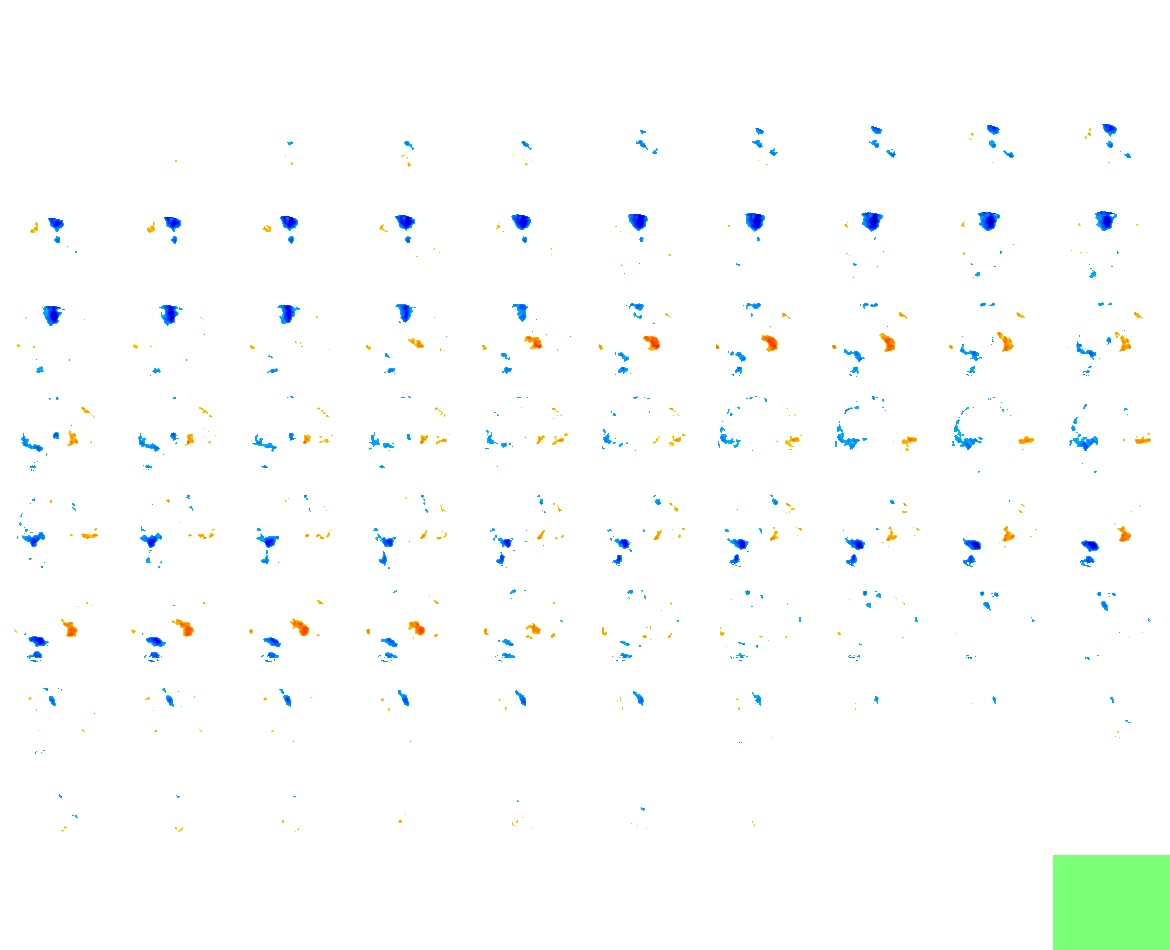

In [27]:
plotting.view_img(
    stat_map_img=img_stat['Test'],
    cmap=cm.jet,
    threshold=z_th,
    symmetric_cmap=True,
    resampling_interpolation='nearest',
    opacity=0.7,
)

True Positive: $MAP_{striatum} \cap MAP_{fMRI}$ = $MAP_{striatum} \cap MAP_{fMRI>Z_{threshold}}$

False Positive: $MAP^{c}_{striatum} \cap MAP_{fMRI}$ = $(MAP_{full}-MAP_{striatum}) \cap MAP_{fMRI>Z_{threshold}}$

True Negative: $MAP^{c}_{striatum} \cap MAP^{c}_{fMRI}$ = $(MAP_{full}-MAP_{striatum}) \cap MAP_{fMRI<Z_{threshold}}$

False Negative: $MAP_{striatum} \cap MAP^{c}_{fMRI}$ = $MAP_{striatum} \cap MAP_{fMRI<Z_{threshold}}$

In [28]:
## Grinding
TPR = {}
FPR = {}
for cond, img in img_stat.items():
    TPR[cond] = []
    FPR[cond] = []
    for z_th in np.linspace(start=-8., stop=8., num=33):
        ## True Positive
        TP = img.get_fdata()[img_roi['striatum'].get_fdata()>0]
        TP = TP[TP >= z_th]

        ## False Positive (full_mask>0 & striatum==0 -> reverse straitum)
        FP = img.get_fdata()[(img_roi['full'].get_fdata()>0)&(img_roi['striatum'].get_fdata()==0)]
        FP = FP[FP >= z_th]

        ## True Negative
        TN = img.get_fdata()[(img_roi['full'].get_fdata()>0)&(img_roi['striatum'].get_fdata()==0)]
        TN = TN[TN < z_th]

        ## False Negative
        FN = img.get_fdata()[img_roi['striatum'].get_fdata()>0]
        FN = FN[FN < z_th]

        TPR[cond].append(TP.shape[0]/(FN.shape[0]+TP.shape[0]))
        FPR[cond].append(FP.shape[0]/(TN.shape[0]+FP.shape[0]))

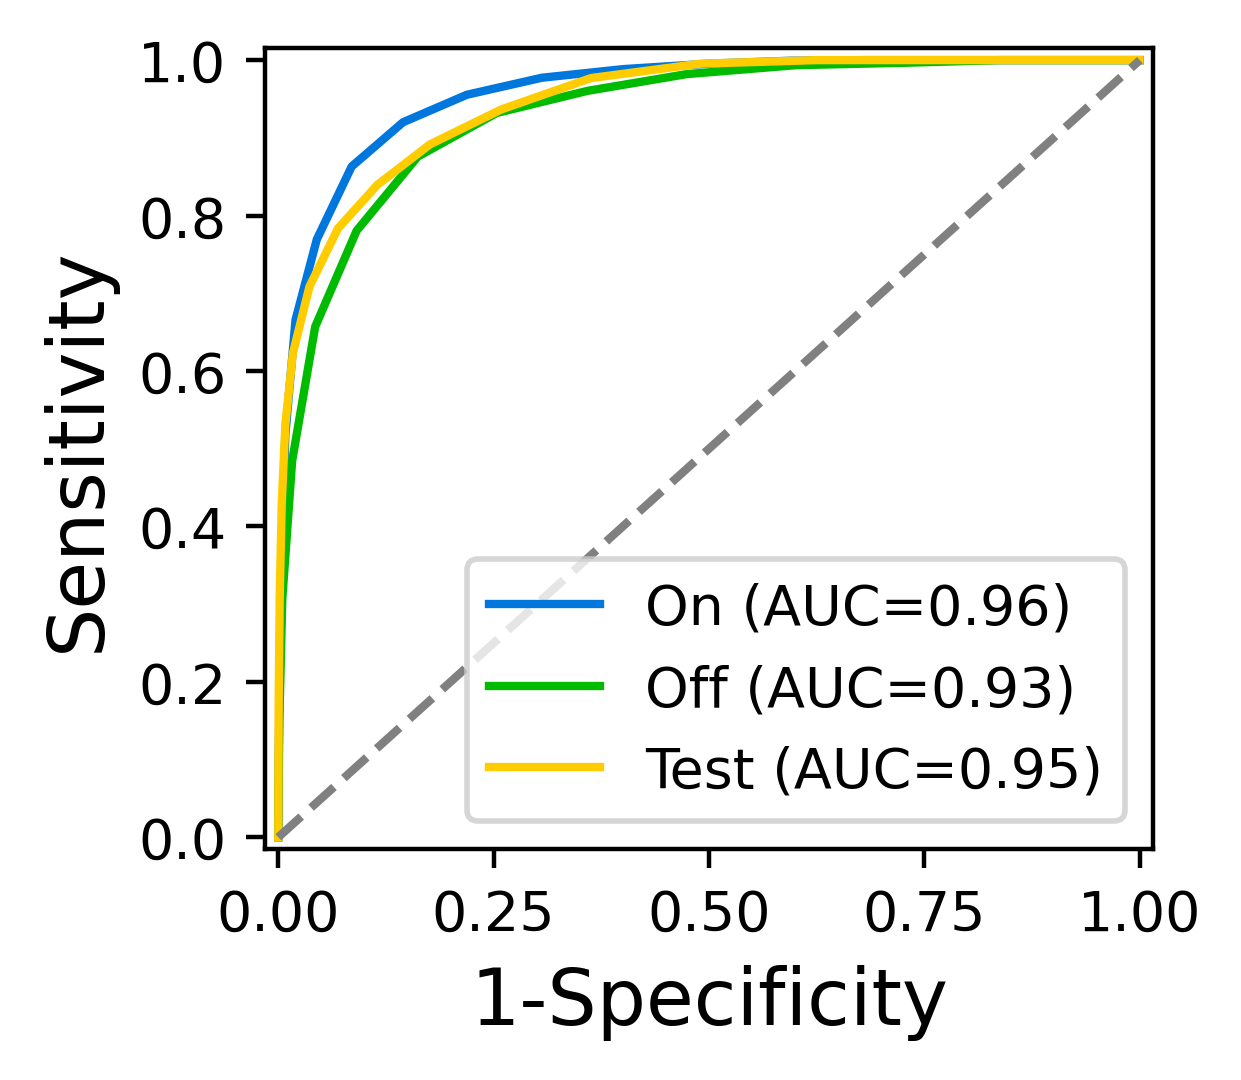

In [29]:
# list_cond = ['On','Off','Test']

fig, ax = plt.subplots(figsize=np.array([4, 3.5])*0.8, dpi=400)

for ii, cond in enumerate(list_cond):
    AUC = auc(FPR[cond], TPR[cond])
    ax.plot(FPR[cond], TPR[cond], '-', color=palette[ii], label='%s (AUC=%.2f)'%(cond,AUC))
#     ax.text(0.25, 0.75, 'AUC=%.2f'%AUC, color=palette[ii])

ax.legend(loc='lower right')
ax.plot([0,1],[0,1], ls='--', color='gray')
ax.set_ylabel("Sensitivity", fontsize=14)
ax.set_xlabel("1-Specificity", fontsize=14)
ax.set(xlim=(-.015,1.015), ylim=(-0.015,1.015))

fig.tight_layout()

In [30]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GL/results/fig.2-b.png'
    , facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

---

## fig 2-c.

In [31]:
imgs = {}

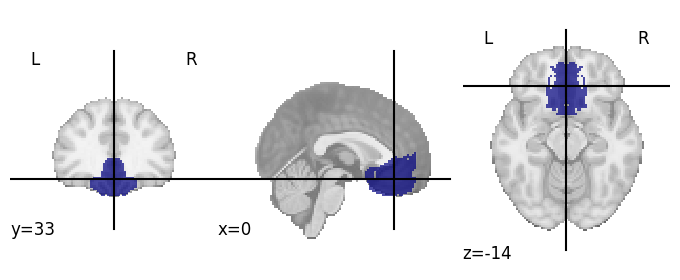

In [32]:
imgs['VmPFC'] = image.math_img(
    img1=join(dir_mask, 'resam.MNI_VmPFC.nii')
    , formula='img1>0'
)
plotting.plot_roi(imgs['VmPFC'])

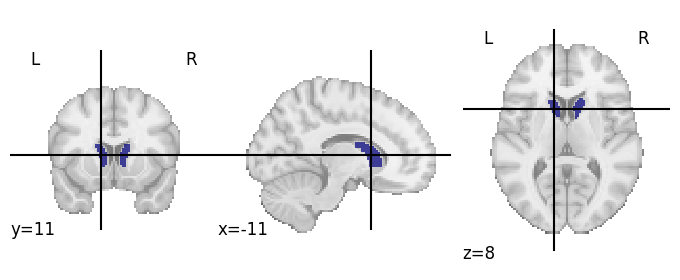

In [33]:
imgs['Caudate'] = image.math_img(
    img1=join(dir_mask, 'resam.TTatlas.caudate.nii'),
    img2=join(dir_mask, 'HarvardOxford-sub-maxprob-thr0-1mm.caudate.resampled.nii'),
    formula='(img1>0)*(img2>0)'
)
plotting.plot_roi(imgs['Caudate'])

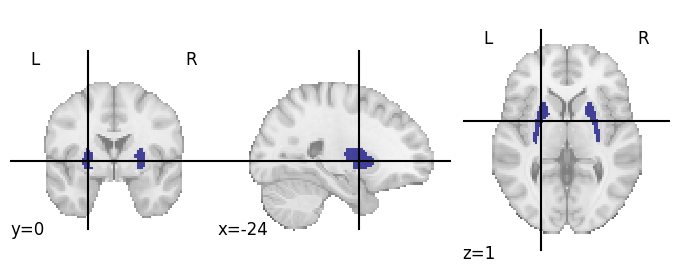

In [34]:
imgs['Putamen'] = image.math_img(
    img1=join(dir_mask, 'resam.TTatlas.putamen.nii'),
    img2=join(dir_mask, 'HarvardOxford-sub-maxprob-thr0-1mm.putamen.resampled.nii'),
    formula='(img1>0)*(img2>0)'
)
plotting.plot_roi(imgs['Putamen'])

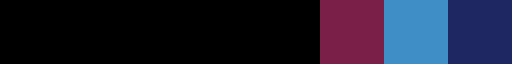

In [35]:
# palette = ['#E5A726','#09218C','#78DA29']
palette = ['#7a2048','#408ec6','#1e2761']
cmap = colors.ListedColormap([*[(0,0,0) for _ in range(5)], *palette])
cmap

/home/sungbeenpark/anaconda3/envs/GL/lib/python3.9/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


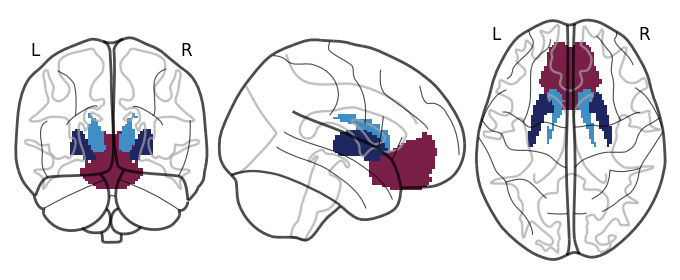

In [36]:
imgs_mask = image.math_img(
    img1=imgs['VmPFC'], img2=imgs['Caudate'], img3=imgs['Putamen'],
    formula='(img1>0)*(img2==0)*(img3==0)*1 + (img1==0)*(img2>0)*(img3==0)*2 + (img1==0)*(img2==0)*(img3>0)*3'
)
plotting.plot_glass_brain(imgs_mask, cmap=cmap)

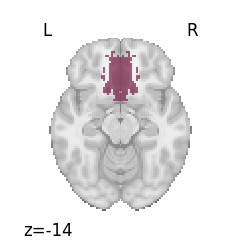

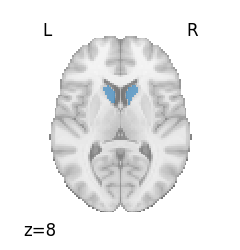

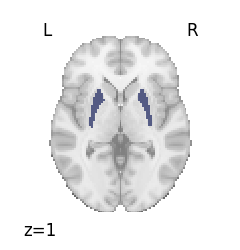

In [37]:
list_z = [-14, 8, 1]
for ii, (roi, img) in enumerate(imgs.items()):
    plotting.plot_roi(
        img, 
        display_mode='z', cut_coords=[list_z[ii]],
        cmap=colors.ListedColormap(cmap(0.5+0.125*(ii+1)))
    )

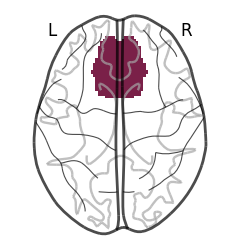

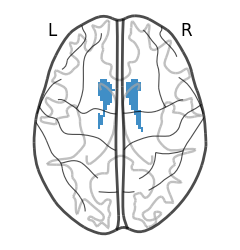

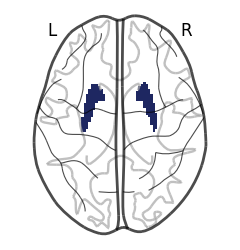

In [38]:
list_z = [-14, 8, 1]
for ii, (roi, img) in enumerate(imgs.items()):
    plotting.plot_glass_brain(
        img, 
        display_mode='z', cut_coords=[list_z[ii]],
        cmap=colors.ListedColormap(cmap(0.5+0.125*(ii+1)))
    )

In [39]:
masker = NiftiLabelsMasker(
    labels_img=imgs_mask, labels=['VmPFC', 'Caudate', 'Putamen']
    , verbose=0, memory=dir_cache
)
makedirs(dir_cache, exist_ok=True)

In [40]:
df = pd.DataFrame()

for cond in list_cond:
    print(cond)
    if cond == 'Test':
        tmp = cond.lower()
    else:
        tmp = 'on_off'
    list_fname = sorted(glob(join(dir_stat,'GL??/%s/stats.Rew.GL??.%s.nii'%(tmp,tmp))))

    for ii, fname in enumerate(tqdm(list_fname)):
        subj = fname.split('.')[-3]
        
        if cond == 'Test':
            img = image.load_img(fname)
            img = img.slicer[:,:,:,0,3]
        else:
            tmp = 'on_off'
            img = image.load_img(fname)
            if cond == 'On':
                img = img.slicer[:,:,:,0,3]
            elif cond == 'Off':
                img = img.slicer[:,:,:,0,8]
                
        betas = masker.fit_transform(img)[0]
        for roi, beta in zip(masker.labels, betas):
            new_row = pd.Series(
                {
                    'subj':subj, 'condition':cond, 'ROI':roi, 'beta':beta 
                }
            )
            df = pd.concat(
                [df, new_row.to_frame().T]
                , axis='index'
                , ignore_index=True
            )
df.set_index('subj', inplace=True)

On


100%|██████████| 24/24 [00:00<00:00, 27.90it/s]


Off


100%|██████████| 24/24 [00:00<00:00, 28.02it/s]


Test


100%|██████████| 24/24 [00:00<00:00, 28.05it/s]


In [41]:
df

condition      ROI      beta
subj                             
GL03        On    VmPFC  0.232596
GL03        On  Caudate    0.2182
GL03        On  Putamen  0.414464
GL04        On    VmPFC  0.523874
GL04        On  Caudate  0.435266
...        ...      ...       ...
GL27      Test  Caudate  0.318515
GL27      Test  Putamen  0.117707
GL29      Test    VmPFC  0.148118
GL29      Test  Caudate  0.037183
GL29      Test  Putamen  0.482691

[216 rows x 3 columns]

---

One sample t-test

In [42]:
for roi in ['VmPFC','Caudate','Putamen']:
    print('### %s ###'%roi)
    for cond in ['On','Off','Test']:
        tmp = df[(df.condition==cond)&(df.ROI==roi)]
        a = tmp.beta
        tval, pval = stats.ttest_1samp(a=a.astype(float),popmean=0)
        print(
            '%s: t(%d)=%.3f, p=%.4e (%s)'%(cond,len(a)-1,tval,pval,convert_pvalue_to_asterisks(pval))
        )
    print('')

### VmPFC ###
On: t(23)=2.337, p=2.8538e-02 (*)
Off: t(23)=-1.297, p=2.0757e-01 (ns)
Test: t(23)=1.227, p=2.3207e-01 (ns)

### Caudate ###
On: t(23)=5.069, p=3.9351e-05 (****)
Off: t(23)=7.164, p=2.6976e-07 (****)
Test: t(23)=0.349, p=7.3043e-01 (ns)

### Putamen ###
On: t(23)=6.791, p=6.3116e-07 (****)
Off: t(23)=7.229, p=2.3324e-07 (****)
Test: t(23)=3.151, p=4.4758e-03 (**)



---

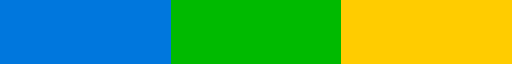

In [43]:
tmp = cm.nipy_spectral.resampled(5)
palette = tmp(np.linspace(0,1,6))[1:4]
colors.ListedColormap(palette)

/tmp/ipykernel_1290559/2870030029.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), fontsize=14)


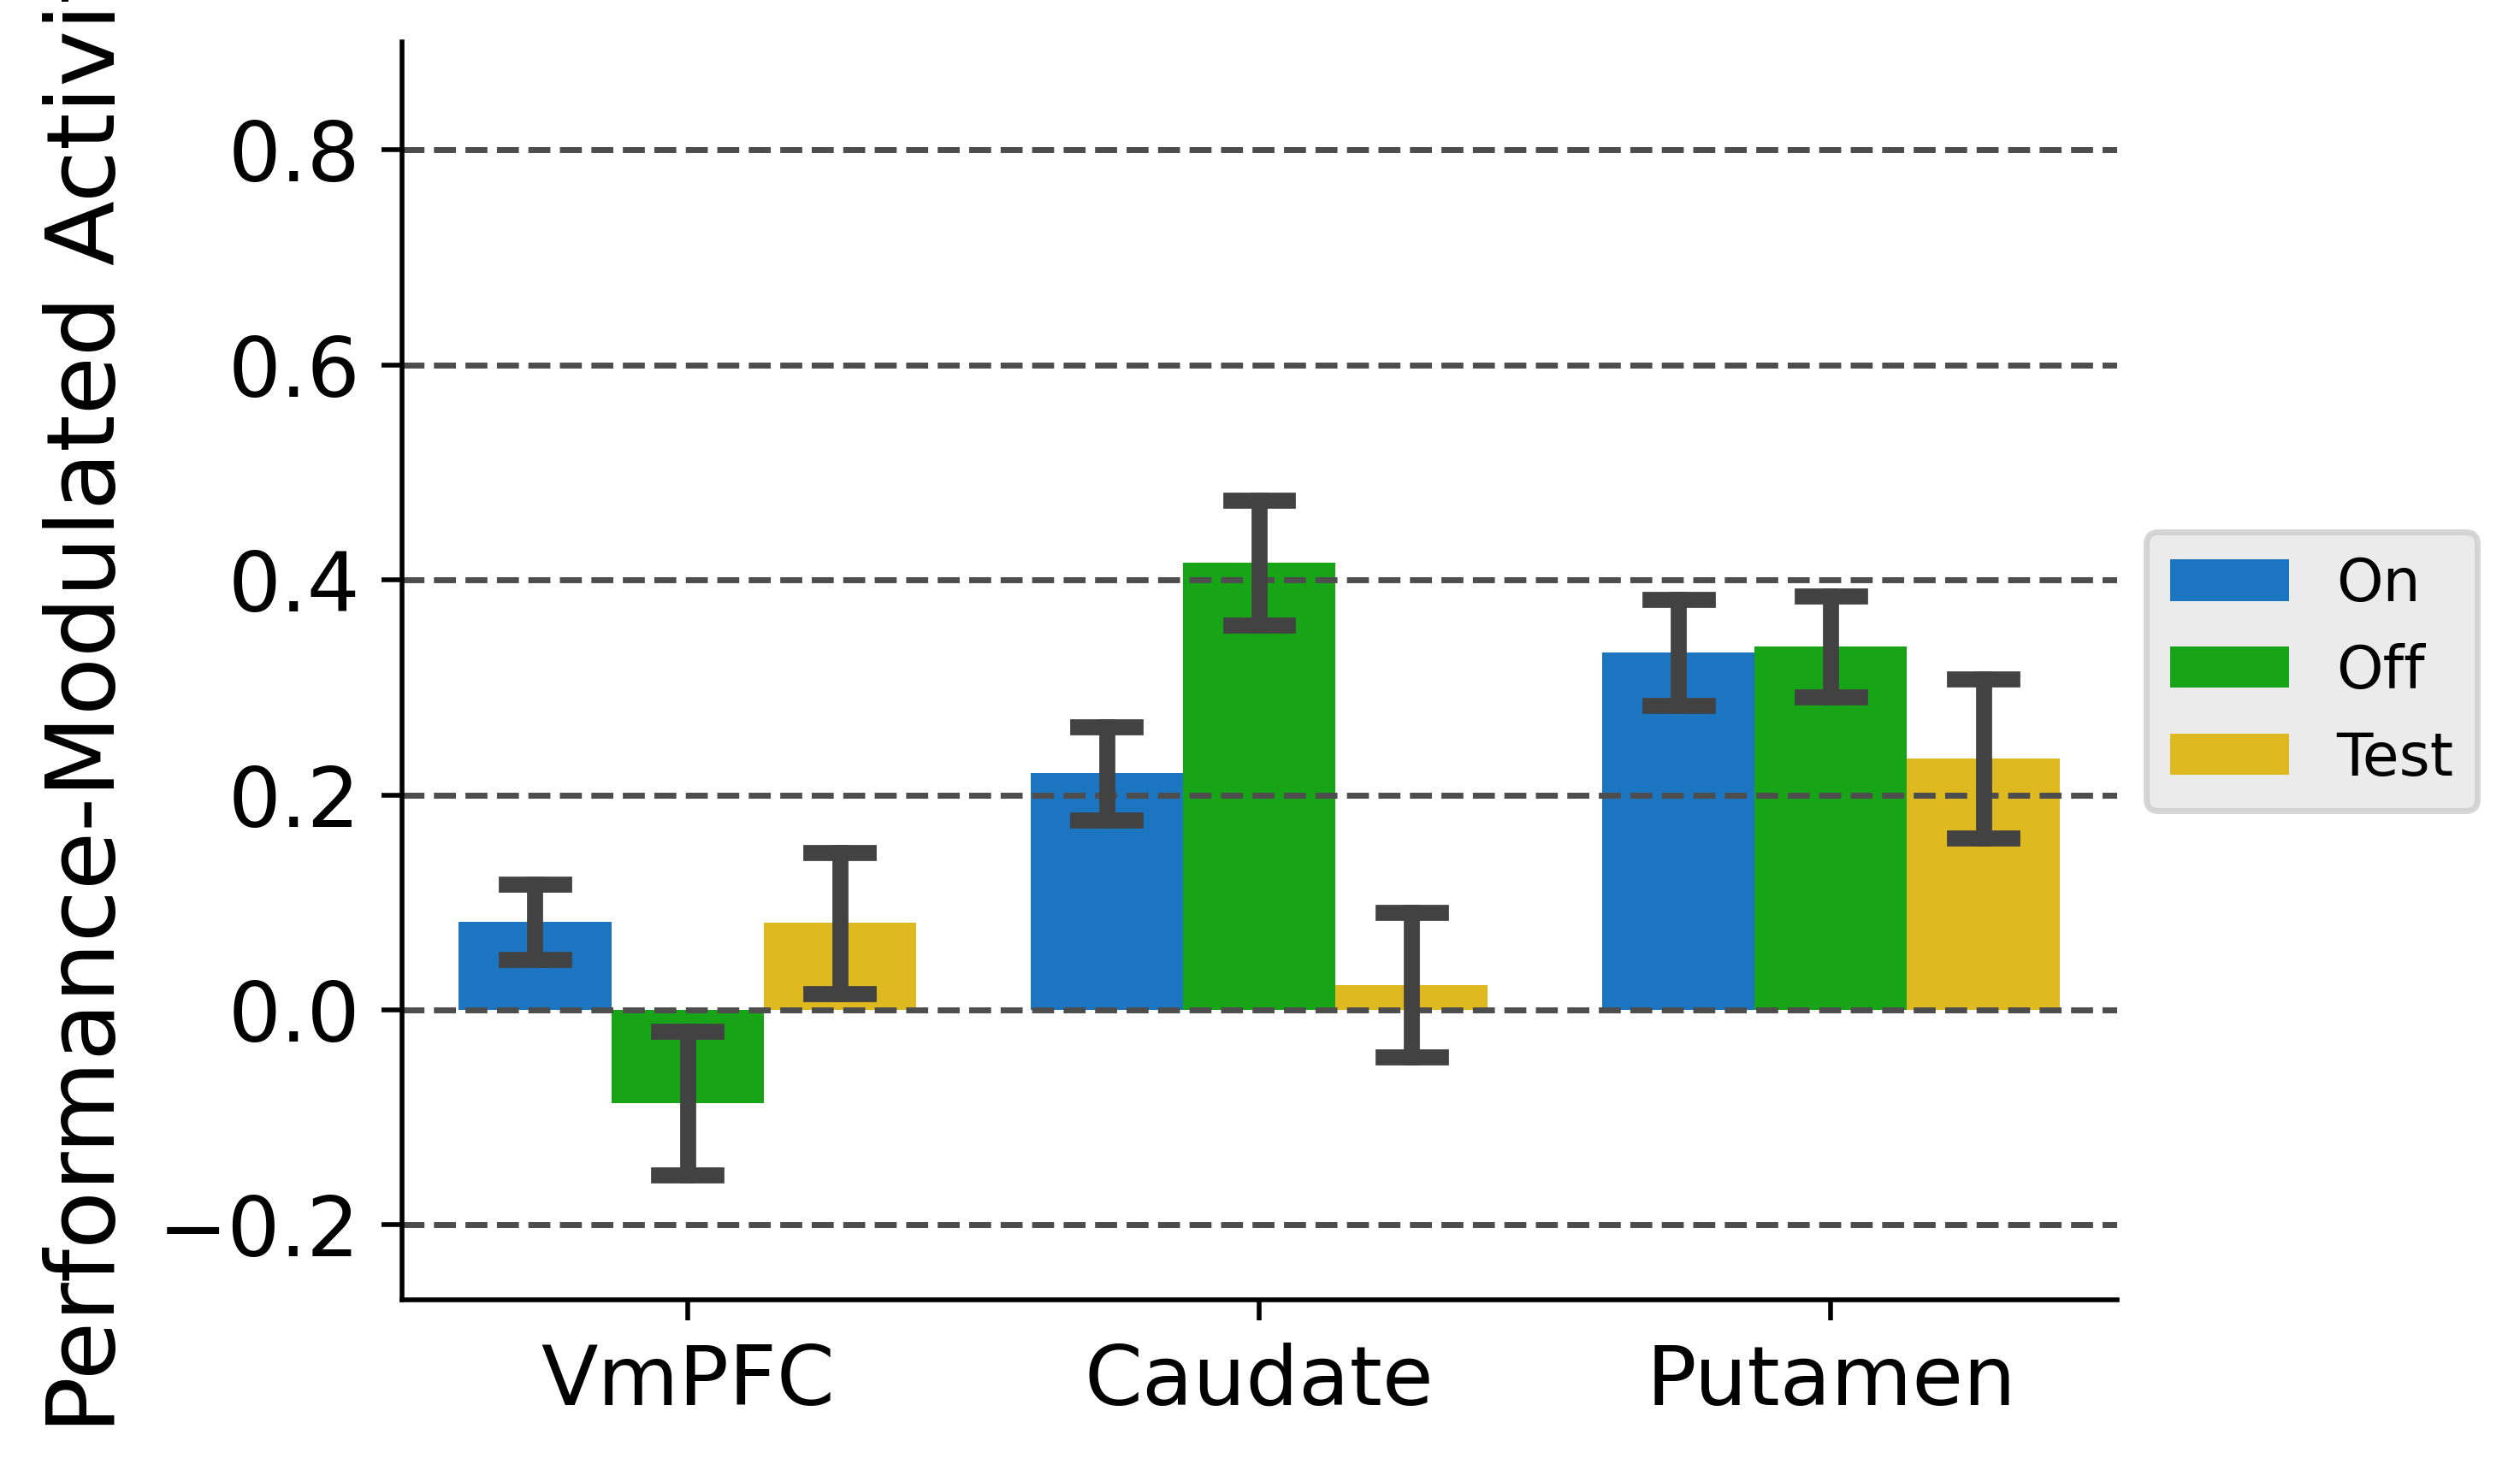

In [44]:
list_ = ['VmPFC', 'Caudate', 'Putamen']

fig, ax = plt.subplots(figsize=np.array([1.7*len(list_),3])*1.175, dpi=500)

g = sns.barplot(
    data=df, x='ROI', y='beta', hue='condition'
    , order=list_
    , errorbar='se', capsize=0.1
    , palette=palette
    , ax=ax
)

g.legend(
    bbox_to_anchor=(1., 0.5), loc='center left',
    ncol=1,
    fontsize=10, facecolor=(0.9,0.9,0.9)
)
g.set_ylim(-0.27, 0.9)
g.set_ylabel('Performance-Modulated Activity', fontsize=16, rotation=90)
g.set_yticklabels(g.get_yticklabels(), fontsize=14)
g.set_xlim(-0.5,len(list_)-0.5)
g.set_xlabel('')
g.set_xticklabels(g.get_xticklabels(), fontsize=14)
g.grid(axis='y', color=(0.3,0.3,0.3,0), linewidth=1, linestyle='--')

sns.despine()
fig.tight_layout()

In [45]:
list_hue = g.get_legend_handles_labels()[-1]
list_xlabel = []
for t in g.get_xticklabels():
    list_xlabel.append(t.get_text())
print(list_xlabel)
print(list_hue)

['VmPFC', 'Caudate', 'Putamen']
['On', 'Off', 'Test']


In [46]:
list_x = []
for child in g.get_children():
    if type(child) == lines.Line2D:
        child.get_bbox().width
#         print(child.get_bbox())
        x0 = child.get_bbox().x0
        x1 = child.get_bbox().x1
        list_x.append('%.4f'%((x0+x1)*0.5))
list_x = np.unique(list_x).astype(float)
list_x.sort()
list_x

array([-0.2667,  0.    ,  0.2667,  0.7333,  1.    ,  1.2667,  1.7333,
        2.    ,  2.2667])

VmPFC
On vs. Off: t=3.029704, p=0.0060(**)
On vs. Test: t=0.015270, p=0.9879(ns)
Off vs. Test: t=-1.882601, p=0.0725(ns)
Caudate
On vs. Off: t=-4.218789, p=0.0003(***)
On vs. Test: t=3.417229, p=0.0024(**)
Off vs. Test: t=5.470570, p=0.0000(****)
Putamen
On vs. Off: t=-0.114628, p=0.9097(ns)
On vs. Test: t=1.741351, p=0.0950(ns)
Off vs. Test: t=1.529603, p=0.1398(ns)


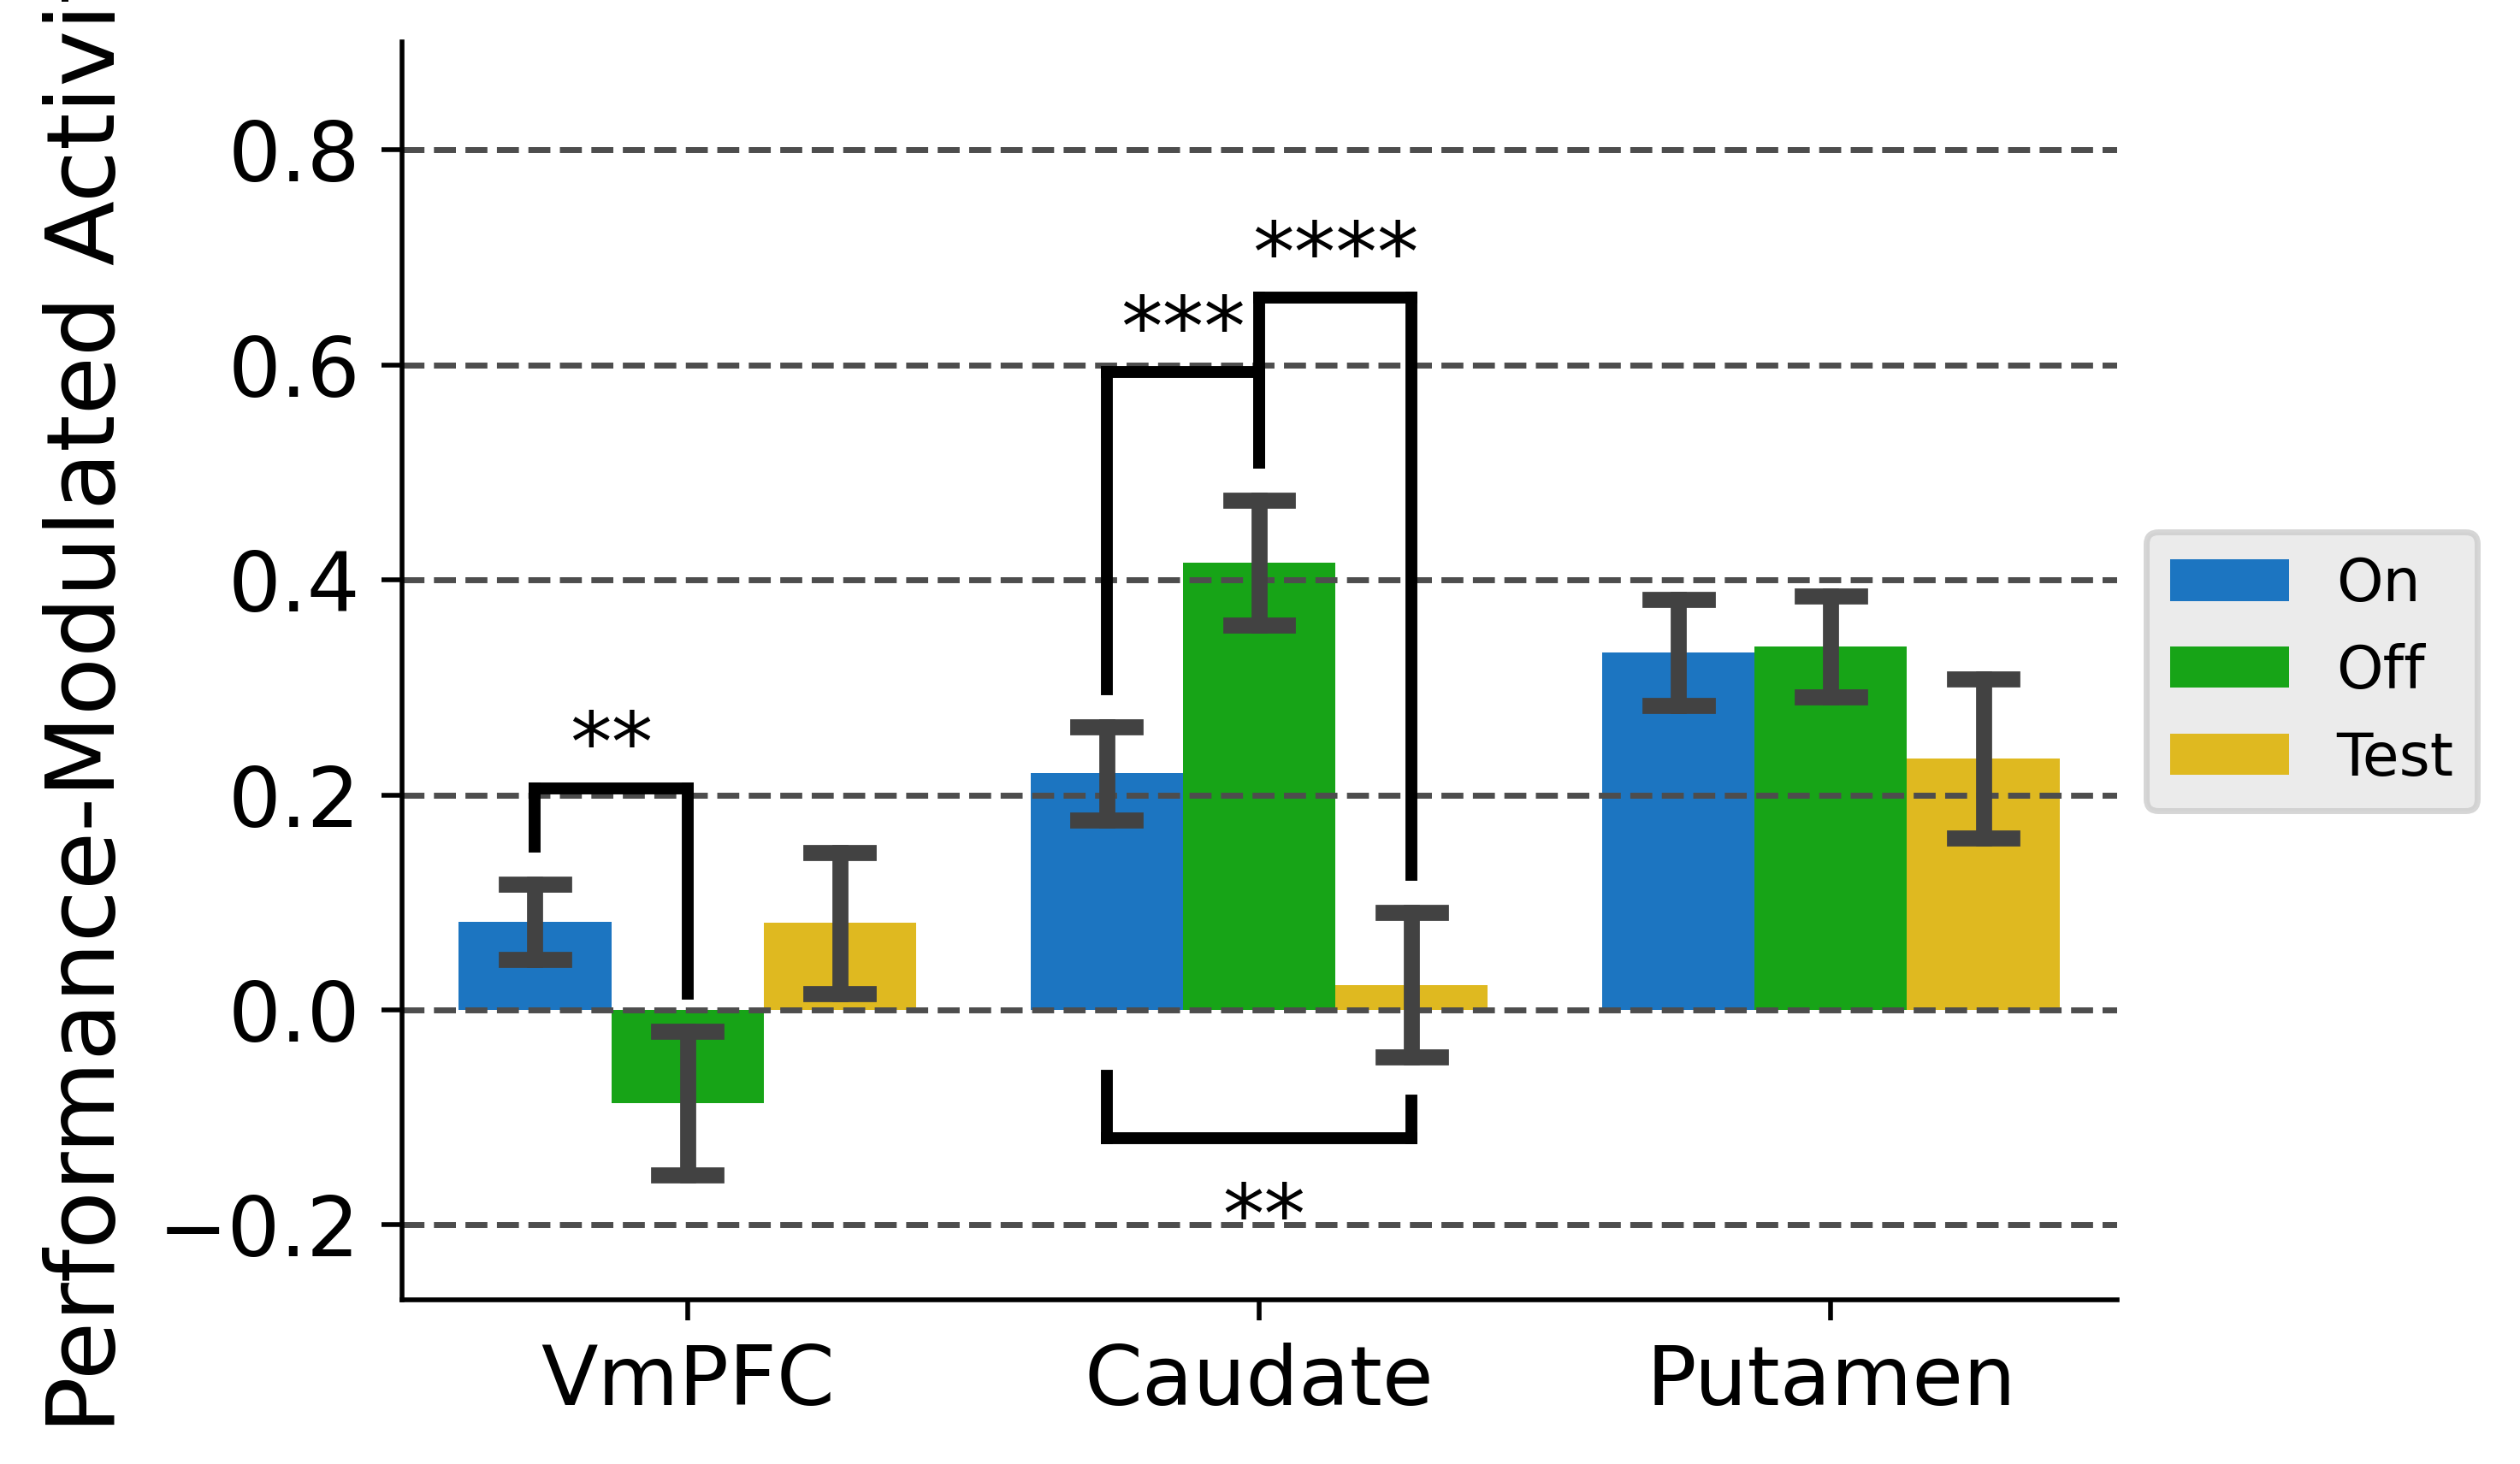

In [47]:
dy = np.diff(g.get_ylim())[0]*0.03

for ii, xlabel in enumerate(list_xlabel):
    print(xlabel)
    for jj, hue1 in enumerate(list_hue):
        x1 = ii + list_x[jj]
        a = df[(df.ROI==xlabel)&(df.condition==hue1)].beta
        for kk, hue2 in enumerate(list_hue[jj+1:]):
            x2 = ii + list_x[jj+1+kk]
            b = df[(df.ROI==xlabel)&(df.condition==hue2)].beta
            tval, pval = stats.ttest_rel(a,b)
            print('%s vs. %s: t=%3f, p=%.4f(%s)'%(hue1,hue2,tval,pval,convert_pvalue_to_asterisks(pval)))

            if pval <= 0.05:
                if (hue1=='On')&(hue2=='Test'):
                    y1 = min(0,a.mean())-a.sem()-dy*0.5
                    y2 = min(0,b.mean())-b.sem()-dy*0.5
                    y = min(0,y1,y2)-dy
                    va = 'top'
                    ro = 180
                else:
                    y1 = a.mean()+a.sem()+dy
                    y2 = b.mean()+b.sem()+dy
                    y = max(y1,y2)+abs(y1-y2)*0.4
                    va = 'bottom'
                    ro = 0
    
                g.plot([x1,x1],[y1,y], 'k-', linewidth=2)
                g.plot([x2,x2],[y2,y], 'k-', linewidth=2)
                g.plot([x1,x2],[y,y], 'k-', linewidth=2)
                g.text(
                    (x1+x2)*0.5, y,
                    convert_pvalue_to_asterisks(pval),
                    fontsize = 14,
                    ha = 'center', va = va,
                    rotation = ro
                )

fig

/tmp/ipykernel_1290559/3087243814.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_1290559/3087243814.py:17: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


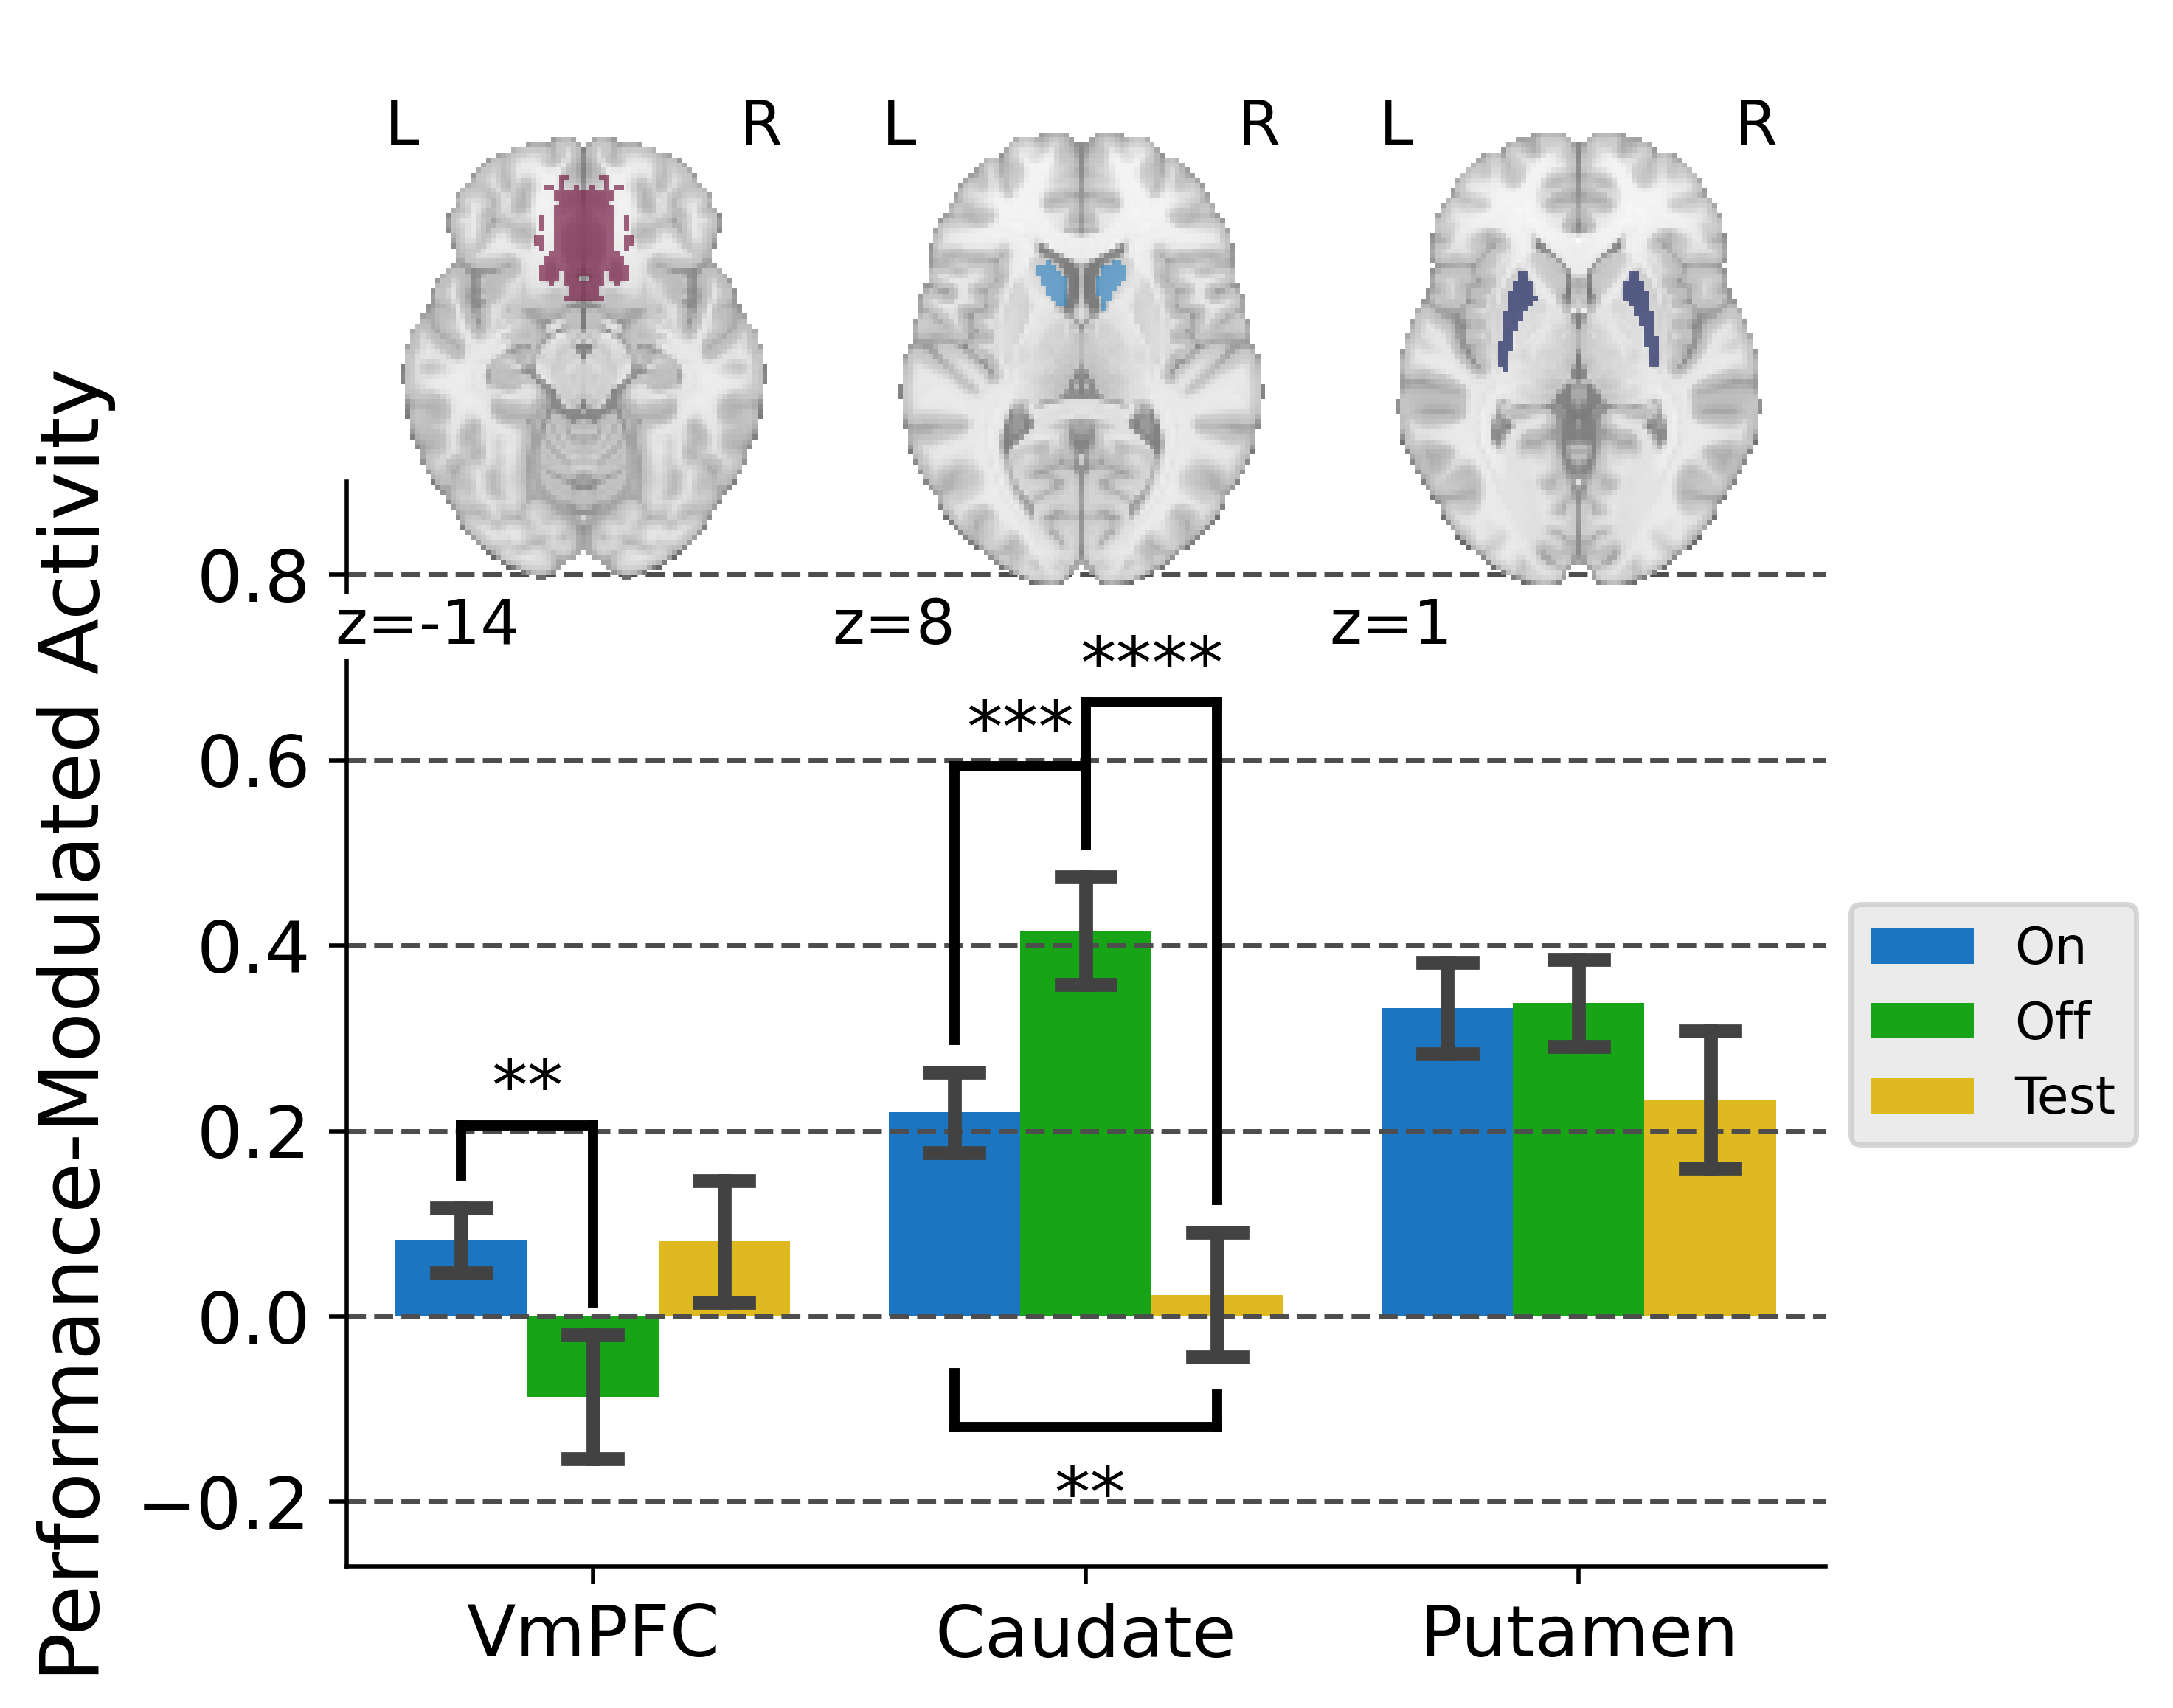

<Figure size 640x480 with 0 Axes>

In [48]:
for ii, (roi, img) in enumerate(imgs.items()):
    ax_insert = fig.add_axes([0.16 + 0.225*ii, 0.8, 0.225, 0.5])
    plotting.plot_roi(
        img, 
        display_mode='z', cut_coords=[list_z[ii]],
        cmap=colors.ListedColormap(cmap(0.5+0.125*(ii+1))),
        axes=ax_insert
    )
#     plotting.plot_glass_brain(
#         img, 
#         display_mode='z', cut_coords=[list_z[ii]],
#         cmap=colors.ListedColormap(cm.jet(0.01)),
#         axes=ax_insert
#     )
    sns.despine()

fig.tight_layout()

fig

In [49]:
for cond in ['On','Off']:
    tmp = df[df.condition==cond]
    a = tmp[tmp.ROI=='Caudate'].beta
    b = tmp[tmp.ROI=='Putamen'].beta
    tval, pval = stats.ttest_rel(a,b)
    print(
        '(%s) Caudate vs. Putamen: t(%d)=%.4f, p=%.4e (%s)'\
        %(cond,len(a)-1,tval,pval,convert_pvalue_to_asterisks(pval))
    )

(On) Caudate vs. Putamen: t(23)=-3.6202, p=1.4370e-03 (**)
(Off) Caudate vs. Putamen: t(23)=2.2740, p=3.2618e-02 (*)


In [50]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GL/results/fig.2-c.png'
    , facecolor=[1,1,1,1], bbox_inches = "tight"
)

---

ANOVA

In [51]:
tmp = df.astype({'beta':float}).reset_index()
tmp

subj condition      ROI      beta
0    GL03        On    VmPFC  0.232596
1    GL03        On  Caudate  0.218200
2    GL03        On  Putamen  0.414464
3    GL04        On    VmPFC  0.523874
4    GL04        On  Caudate  0.435266
..    ...       ...      ...       ...
211  GL27      Test  Caudate  0.318515
212  GL27      Test  Putamen  0.117707
213  GL29      Test    VmPFC  0.148118
214  GL29      Test  Caudate  0.037183
215  GL29      Test  Putamen  0.482691

[216 rows x 4 columns]

In [52]:
aov = pg.rm_anova(
    data=tmp[(tmp.ROI!='VmPFC')&(tmp.condition!='Test')]
    , dv='beta'
    , subject='subj'
    , within=['condition','ROI']
    , effsize='np2'
)
aov

Source        SS  ddof1  ddof2        MS          F     p-unc  \
0        condition  0.243389      1     23  0.243389   5.296606  0.030765   
1              ROI  0.007254      1     23  0.007254   0.420477  0.523121   
2  condition * ROI  0.217154      1     23  0.217154  25.972607  0.000037   

   p-GG-corr       np2  eps  
0   0.030765  0.187182  1.0  
1   0.523121  0.017953  1.0  
2   0.000037  0.530350  1.0

---